In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer
from scalar_features import ScalarFeaturizer
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

In [2]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1_twin'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPE_rall'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'
print(fn_geo_features)

../data/geometric_features/geometric_features_TNG100-1/geometric_features_nstarpartmin1_twin_xminPE_rall.npy


In [4]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [5]:
n_groups = [[0,1,2], [3,4,5,6,7], [8,9,10]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)

In [6]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')

In [16]:
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('v200m')

In [23]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)
N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 20098


In [33]:
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])

Text(0, 0.5, 'count')

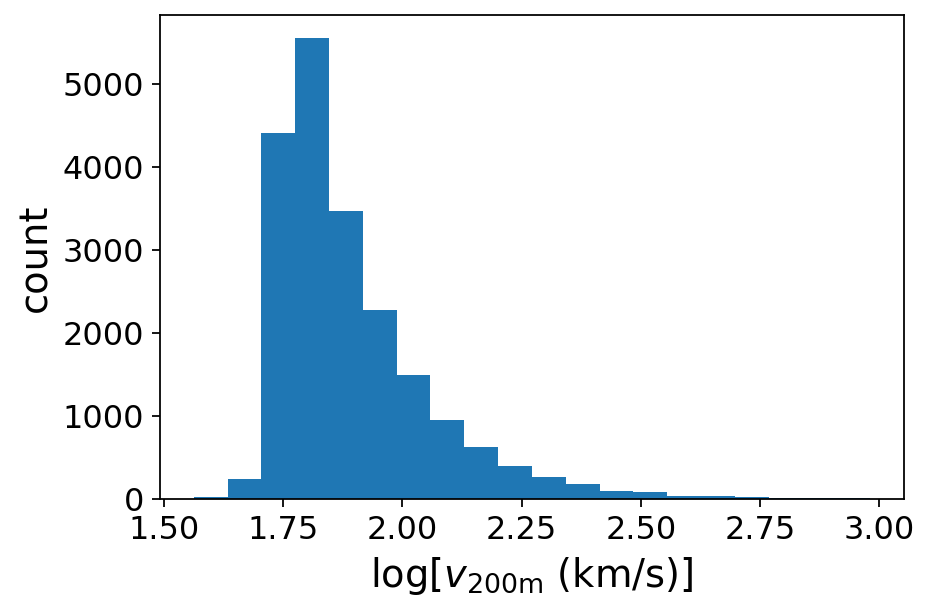

In [25]:
plt.hist(np.log10(v_200m), bins=20)
plt.xlabel(r'$\mathrm{log}[v_{200\mathrm{m}}$ (km/s)]')
plt.ylabel('count')

Text(0, 0.5, '$R_{200m}$ ($h^{-1} \\,$ ckpc)')

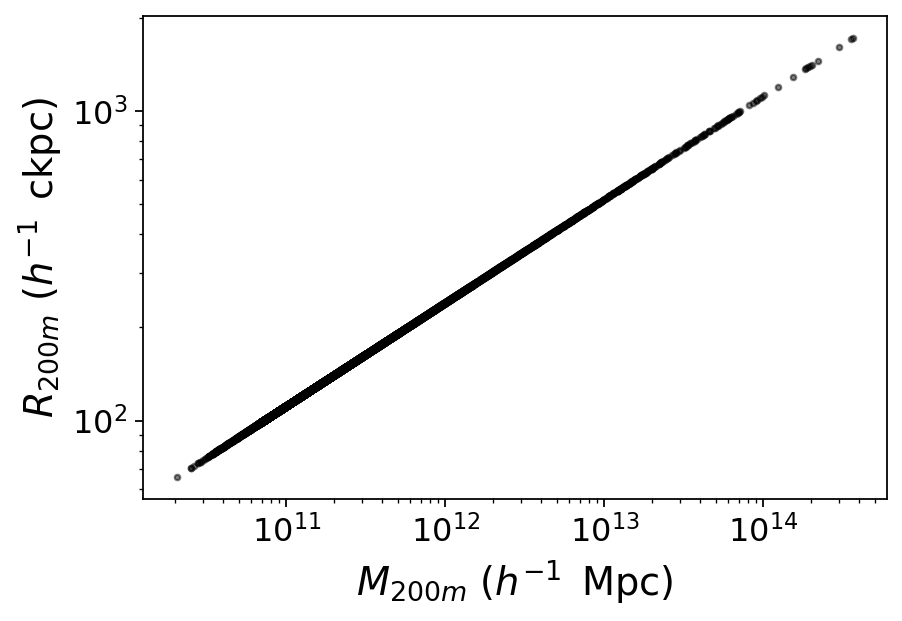

In [39]:
plt.scatter(m_200m*mass_multiplier, r_200m, c='k', s=6, alpha=0.5)
plt.loglog()
plt.xlabel(r'$M_{200m}$ ($h^{-1} \,$ Mpc)')
plt.ylabel(r'$R_{200m}$ ($h^{-1} \,$ ckpc)')

Text(0, 0.5, '$V_{200m}$ (km/s)')

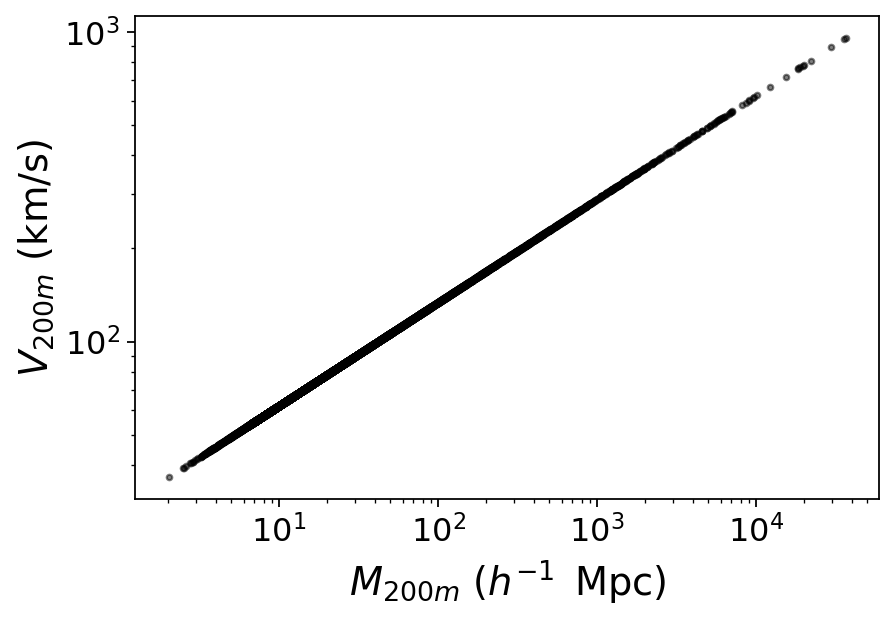

In [40]:
plt.scatter(m_200m, v_200m, c='k', s=6, alpha=0.5)
plt.loglog()
plt.xlabel(r'$M_{200m}$ ($h^{-1} \,$ Mpc)')
plt.ylabel(r'$V_{200m}$ (km/s)')

## Set up general scalar featurizer

In [8]:
# scalar info
scalar_featurizer = ScalarFeaturizer(geo_feature_arr_rebinned)
scalar_featurizer.compute_MXV_from_features()
scalar_featurizer.rescale_geometric_features(scalar_featurizer.M_tot, 
                                             scalar_featurizer.X_rms, 
                                             scalar_featurizer.V_rms)

# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((scalar_featurizer.M_tot, 
                              scalar_featurizer.X_rms,
                              scalar_featurizer.V_rms)).T
x_features_extra = np.log10(x_features_extra)   

## Split train-val-test

In [9]:
frac_train = 0.70
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

print(len(idx_train), len(idx_test), len(idx_val))

14068 3015 3015


## Uncertainties & powerlaw

In [10]:
uncertainties_genel2019 = utils.get_uncertainties_genel2019(log_m_stellar+log_mass_shift, sim_name=sim_name)

In [11]:
log_m_200m_train = log_m_200m[idx_train]
log_m_stellar_train = log_m_stellar[idx_train]
uncertainties_genel2019_train = uncertainties_genel2019[idx_train]
y_val_current_powerlaw_fit_train, params_best_fit, params_initial_guess = utils.fit_broken_power_law(
                                                        log_m_200m_train, log_m_stellar_train, 
                                                        uncertainties=uncertainties_genel2019_train, 
                                                        return_initial_guess=True)
y_val_current_powerlaw_fit = utils.broken_power_law(log_m_200m, *params_best_fit)

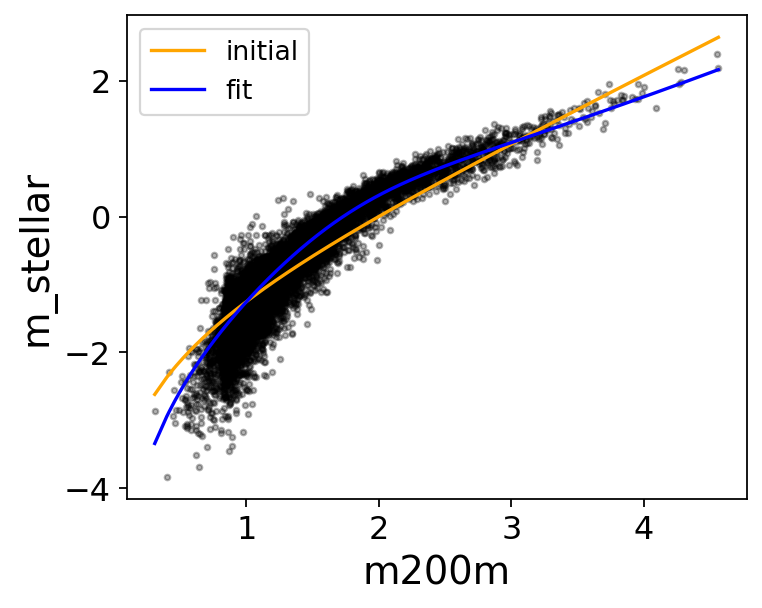

In [12]:
plt.figure(figsize=(5,4))
# sort for plotting niceness
idx_m_200m = np.argsort(log_m_200m_train)
y_initial_train = utils.broken_power_law(log_m_200m_train, *params_initial_guess)
plt.scatter(log_m_200m_train[idx_m_200m], log_m_stellar_train[idx_m_200m], s=6, c='k', alpha=0.3)
plt.plot(log_m_200m_train[idx_m_200m], y_initial_train[idx_m_200m], color='orange', label='initial')
plt.plot(log_m_200m_train[idx_m_200m], y_val_current_powerlaw_fit_train[idx_m_200m], color='blue', label='fit')
plt.xlabel('m200m')
plt.ylabel('m_stellar')
plt.legend(fontsize=12)

## Baseline

y_scalar_test: -4.0802217 2.0739539
scale_y: -4.0802217 2.0739539
predict_test: -4.0802217 2.0739539
0.2502555520501989


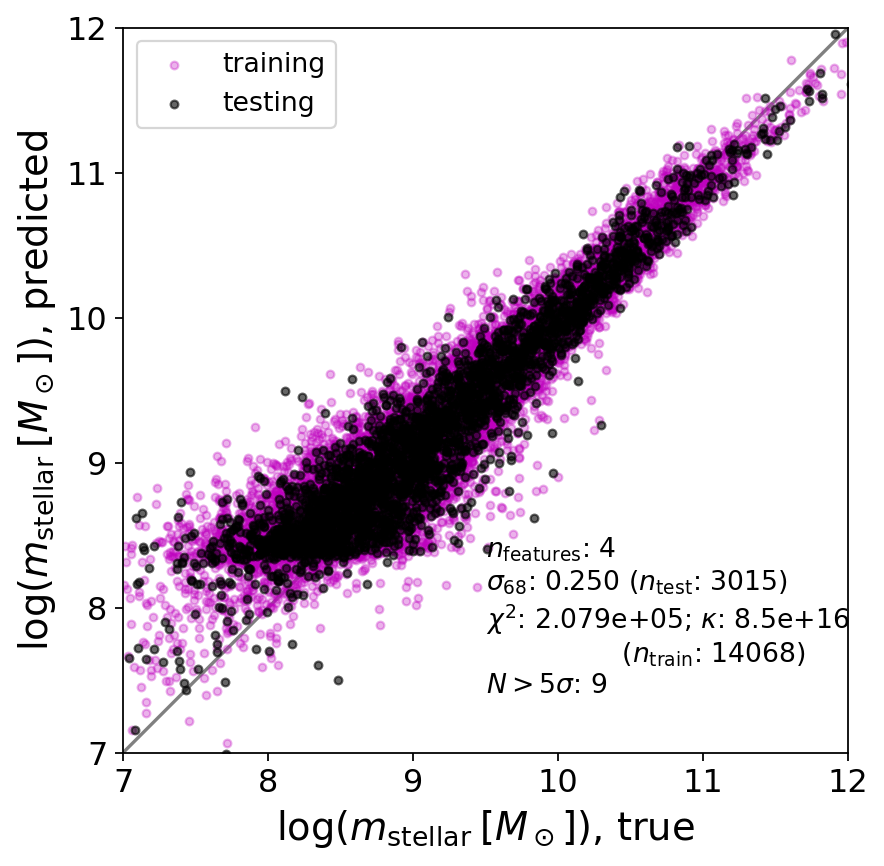

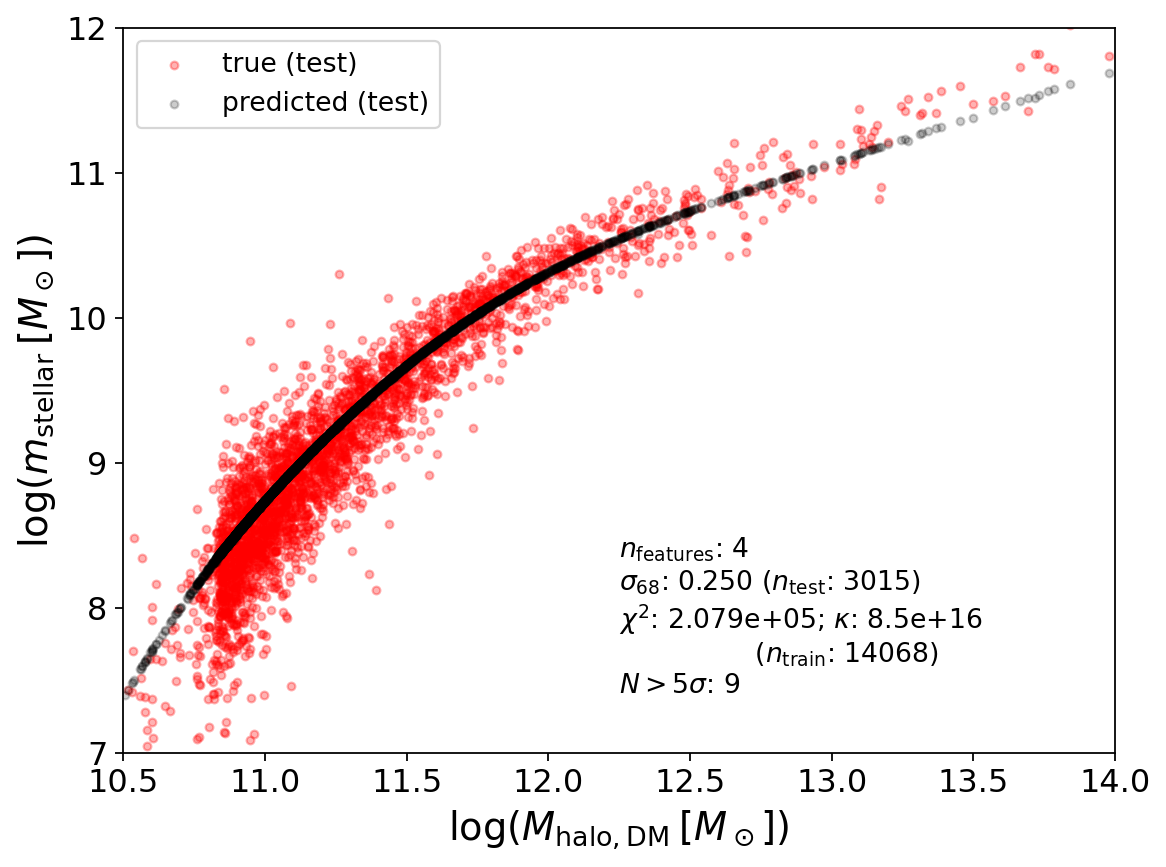

In [23]:
ones_features = np.atleast_2d(np.ones(len(log_m_stellar))).T
x_extra_mtot = np.atleast_2d(np.log10(scalar_featurizer.M_tot)).T
fitter = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_extra_mtot)
fitter.split_train_test(idx_train, idx_val)
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m, log_mass_shift=log_mass_shift)
error_powerlawM, _ = utils.compute_error(fitter, test_error_type='percentile')
print(error_powerlawM)

## Full scalar featurizer

In [14]:
from IPython.display import display, Markdown

In [15]:
m_order_max = 2
x_order_max = 4
v_order_max = 4
scalar_tag = f'_3bins_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

scalar_featurizer.load_features(fn_scalar_features)
names = [f.name for f in scalar_featurizer.scalar_feature_arr[0]]
for name in names:
    display(Markdown('$'+name+'$'))

$g_{000}$

$g_{001}$

$g_{002}$

$\lambda_3(g_{020})$

$\lambda_2(g_{020})$

$\lambda_1(g_{020})$

$\lambda_2(g_{021})$

$\lambda_3(g_{021})$

$\lambda_1(g_{021})$

$\lambda_3(g_{022})$

$\lambda_2(g_{022})$

$\lambda_1(g_{022})$

$\lambda_1(g_{110})$

$\lambda_2(g_{110})$

$\lambda_3(g_{110})$

$\lambda_3(g_{111})$

$\lambda_2(g_{111})$

$\lambda_1(g_{111})$

$\lambda_1(g_{112})$

$\lambda_2(g_{112})$

$\lambda_3(g_{112})$

$\lambda_1(g_{200})$

$\lambda_3(g_{200})$

$\lambda_2(g_{200})$

$\lambda_2(g_{201})$

$\lambda_3(g_{201})$

$\lambda_1(g_{201})$

$\lambda_1(g_{202})$

$\lambda_2(g_{202})$

$\lambda_3(g_{202})$

$g_{000} \, g_{000}$

$g_{000} \, g_{001}$

$g_{000} \, g_{002}$

$g_{001} \, g_{001}$

$g_{001} \, g_{002}$

$g_{002} \, g_{002}$

$[g_{010}]_j \, [g_{010}]_j$

$\lambda_1(g_{020}) \, g_{000}$

$\lambda_2(g_{020}) \, g_{000}$

$\lambda_3(g_{020}) \, g_{000}$

$\lambda_2(g_{021}) \, g_{000}$

$\lambda_1(g_{020}) \, g_{001}$

$\lambda_3(g_{021}) \, g_{000}$

$[g_{010}]_j \, [g_{011}]_j$

$\lambda_1(g_{021}) \, g_{000}$

$\lambda_2(g_{020}) \, g_{001}$

$\lambda_3(g_{020}) \, g_{001}$

$[g_{010}]_j \, [g_{012}]_j$

$\lambda_1(g_{022}) \, g_{000}$

$\lambda_2(g_{022}) \, g_{000}$

$\lambda_3(g_{022}) \, g_{000}$

$\lambda_2(g_{020}) \, g_{002}$

$\lambda_3(g_{020}) \, g_{002}$

$\lambda_1(g_{020}) \, g_{002}$

$\lambda_2(g_{021}) \, g_{001}$

$\lambda_3(g_{021}) \, g_{001}$

$\lambda_1(g_{021}) \, g_{001}$

$[g_{011}]_j \, [g_{011}]_j$

$\lambda_1(g_{021}) \, g_{002}$

$\lambda_1(g_{022}) \, g_{001}$

$\lambda_2(g_{022}) \, g_{001}$

$\lambda_3(g_{022}) \, g_{001}$

$[g_{011}]_j \, [g_{012}]_j$

$\lambda_3(g_{021}) \, g_{002}$

$\lambda_2(g_{021}) \, g_{002}$

$[g_{012}]_j \, [g_{012}]_j$

$\lambda_1(g_{022}) \, g_{002}$

$\lambda_2(g_{022}) \, g_{002}$

$\lambda_3(g_{022}) \, g_{002}$

$\lambda_1(g_{020}) \, \lambda_1(g_{020})$

$\lambda_3(g_{020}) \, \lambda_3(g_{020})$

$\lambda_1(g_{020}) \, \lambda_3(g_{020})$

$\lambda_2(g_{020}) \, \lambda_3(g_{020})$

$[g_{020}]_{jk} \, [g_{020}]_{jk}$

$\lambda_1(g_{020}) \, \lambda_2(g_{020})$

$\lambda_2(g_{020}) \, \lambda_2(g_{020})$

$\lambda_1(g_{020}) \, \lambda_3(g_{021})$

$\lambda_1(g_{021}) \, \lambda_2(g_{020})$

$\lambda_2(g_{020}) \, \lambda_2(g_{021})$

$\lambda_2(g_{020}) \, \lambda_3(g_{021})$

$\lambda_1(g_{021}) \, \lambda_3(g_{020})$

$\lambda_3(g_{020}) \, \lambda_3(g_{021})$

$[g_{020}]_{jk} \, [g_{021}]_{jk}$

$\lambda_1(g_{020}) \, \lambda_2(g_{021})$

$\lambda_1(g_{020}) \, \lambda_1(g_{021})$

$\lambda_2(g_{021}) \, \lambda_3(g_{020})$

$\lambda_1(g_{020}) \, \lambda_2(g_{022})$

$\lambda_1(g_{020}) \, \lambda_3(g_{022})$

$\lambda_1(g_{022}) \, \lambda_2(g_{020})$

$\lambda_2(g_{020}) \, \lambda_2(g_{022})$

$\lambda_2(g_{020}) \, \lambda_3(g_{022})$

$\lambda_1(g_{022}) \, \lambda_3(g_{020})$

$\lambda_2(g_{022}) \, \lambda_3(g_{020})$

$\lambda_3(g_{020}) \, \lambda_3(g_{022})$

$[g_{020}]_{jk} \, [g_{022}]_{jk}$

$\lambda_1(g_{020}) \, \lambda_1(g_{022})$

$[g_{021}]_{jk} \, [g_{021}]_{jk}$

$\lambda_2(g_{021}) \, \lambda_3(g_{021})$

$\lambda_1(g_{021}) \, \lambda_3(g_{021})$

$\lambda_3(g_{021}) \, \lambda_3(g_{021})$

$\lambda_2(g_{021}) \, \lambda_2(g_{021})$

$\lambda_1(g_{021}) \, \lambda_1(g_{021})$

$\lambda_1(g_{021}) \, \lambda_2(g_{021})$

$\lambda_1(g_{021}) \, \lambda_1(g_{022})$

$\lambda_2(g_{021}) \, \lambda_2(g_{022})$

$\lambda_1(g_{021}) \, \lambda_2(g_{022})$

$\lambda_1(g_{021}) \, \lambda_3(g_{022})$

$[g_{021}]_{jk} \, [g_{022}]_{jk}$

$\lambda_2(g_{021}) \, \lambda_3(g_{022})$

$\lambda_1(g_{022}) \, \lambda_2(g_{021})$

$\lambda_2(g_{022}) \, \lambda_3(g_{021})$

$\lambda_3(g_{021}) \, \lambda_3(g_{022})$

$\lambda_1(g_{022}) \, \lambda_3(g_{021})$

$\lambda_1(g_{022}) \, \lambda_2(g_{022})$

$\lambda_1(g_{022}) \, \lambda_1(g_{022})$

$\lambda_3(g_{022}) \, \lambda_3(g_{022})$

$\lambda_2(g_{022}) \, \lambda_2(g_{022})$

$[g_{022}]_{jk} \, [g_{022}]_{jk}$

$\lambda_2(g_{022}) \, \lambda_3(g_{022})$

$\lambda_1(g_{022}) \, \lambda_3(g_{022})$

$\lambda_2(g_{110}) \, g_{000}$

$[g_{010}]_j \, [g_{100}]_j$

$\lambda_1(g_{110}) \, g_{000}$

$\lambda_3(g_{110}) \, g_{000}$

$\lambda_1(g_{111}) \, g_{000}$

$\lambda_2(g_{111}) \, g_{000}$

$\lambda_3(g_{111}) \, g_{000}$

$\lambda_1(g_{110}) \, g_{001}$

$\lambda_2(g_{110}) \, g_{001}$

$\lambda_3(g_{110}) \, g_{001}$

$[g_{010}]_j \, [g_{101}]_j$

$[g_{100}]_j \, [g_{011}]_j$

$\lambda_1(g_{112}) \, g_{000}$

$\lambda_2(g_{112}) \, g_{000}$

$\lambda_1(g_{110}) \, g_{002}$

$\lambda_2(g_{110}) \, g_{002}$

$\lambda_3(g_{110}) \, g_{002}$

$[g_{010}]_j \, [g_{102}]_j$

$\lambda_3(g_{112}) \, g_{000}$

$[g_{100}]_j \, [g_{012}]_j$

$[g_{011}]_j \, [g_{101}]_j$

$\lambda_1(g_{111}) \, g_{001}$

$\lambda_3(g_{111}) \, g_{001}$

$\lambda_2(g_{111}) \, g_{001}$

$[g_{011}]_j \, [g_{102}]_j$

$\lambda_3(g_{112}) \, g_{001}$

$\lambda_2(g_{112}) \, g_{001}$

$[g_{101}]_j \, [g_{012}]_j$

$\lambda_3(g_{111}) \, g_{002}$

$\lambda_1(g_{112}) \, g_{001}$

$\lambda_2(g_{111}) \, g_{002}$

$\lambda_1(g_{111}) \, g_{002}$

$\lambda_2(g_{112}) \, g_{002}$

$\lambda_3(g_{112}) \, g_{002}$

$[g_{012}]_j \, [g_{102}]_j$

$\lambda_1(g_{112}) \, g_{002}$

$\lambda_1(g_{110}) \, \lambda_2(g_{020})$

$\lambda_2(g_{020}) \, \lambda_2(g_{110})$

$\lambda_2(g_{020}) \, \lambda_3(g_{110})$

$\lambda_1(g_{110}) \, \lambda_3(g_{020})$

$\lambda_2(g_{110}) \, \lambda_3(g_{020})$

$\lambda_1(g_{020}) \, \lambda_2(g_{110})$

$\lambda_3(g_{020}) \, \lambda_3(g_{110})$

$\lambda_1(g_{020}) \, \lambda_3(g_{110})$

$[g_{020}]_{jk} \, [g_{110}]_{jk}$

$\lambda_1(g_{020}) \, \lambda_1(g_{110})$

$[g_{110}]_{jk} \, [g_{021}]_{jk}$

$[g_{020}]_{jk} \, [g_{111}]_{jk}$

$\lambda_2(g_{021}) \, \lambda_3(g_{110})$

$\lambda_1(g_{021}) \, \lambda_3(g_{110})$

$\lambda_2(g_{110}) \, \lambda_3(g_{021})$

$\lambda_2(g_{021}) \, \lambda_2(g_{110})$

$\lambda_1(g_{021}) \, \lambda_2(g_{110})$

$\lambda_1(g_{110}) \, \lambda_2(g_{021})$

$\lambda_1(g_{021}) \, \lambda_1(g_{110})$

$\lambda_3(g_{021}) \, \lambda_3(g_{110})$

$\lambda_1(g_{110}) \, \lambda_3(g_{021})$

$\lambda_3(g_{020}) \, \lambda_3(g_{111})$

$\lambda_2(g_{111}) \, \lambda_3(g_{020})$

$\lambda_1(g_{111}) \, \lambda_3(g_{020})$

$\lambda_2(g_{020}) \, \lambda_3(g_{111})$

$\lambda_2(g_{020}) \, \lambda_2(g_{111})$

$\lambda_1(g_{111}) \, \lambda_2(g_{020})$

$\lambda_1(g_{020}) \, \lambda_3(g_{111})$

$\lambda_1(g_{020}) \, \lambda_2(g_{111})$

$\lambda_1(g_{020}) \, \lambda_1(g_{111})$

$\lambda_1(g_{020}) \, \lambda_1(g_{112})$

$\lambda_1(g_{020}) \, \lambda_2(g_{112})$

$\lambda_1(g_{020}) \, \lambda_3(g_{112})$

$\lambda_3(g_{020}) \, \lambda_3(g_{112})$

$\lambda_2(g_{020}) \, \lambda_2(g_{112})$

$\lambda_2(g_{020}) \, \lambda_3(g_{112})$

$[g_{020}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{112}) \, \lambda_2(g_{020})$

$\lambda_1(g_{112}) \, \lambda_3(g_{020})$

$\lambda_2(g_{112}) \, \lambda_3(g_{020})$

$\lambda_1(g_{110}) \, \lambda_2(g_{022})$

$[g_{110}]_{jk} \, [g_{022}]_{jk}$

$\lambda_3(g_{022}) \, \lambda_3(g_{110})$

$\lambda_2(g_{022}) \, \lambda_3(g_{110})$

$\lambda_1(g_{022}) \, \lambda_3(g_{110})$

$\lambda_2(g_{110}) \, \lambda_3(g_{022})$

$\lambda_2(g_{022}) \, \lambda_2(g_{110})$

$\lambda_1(g_{022}) \, \lambda_2(g_{110})$

$\lambda_1(g_{110}) \, \lambda_3(g_{022})$

$\lambda_1(g_{022}) \, \lambda_1(g_{110})$

$[g_{021}]_{jk} \, [g_{111}]_{jk}$

$\lambda_2(g_{111}) \, \lambda_3(g_{021})$

$\lambda_1(g_{111}) \, \lambda_3(g_{021})$

$\lambda_2(g_{021}) \, \lambda_3(g_{111})$

$\lambda_2(g_{021}) \, \lambda_2(g_{111})$

$\lambda_1(g_{111}) \, \lambda_2(g_{021})$

$\lambda_1(g_{021}) \, \lambda_3(g_{111})$

$\lambda_1(g_{021}) \, \lambda_2(g_{111})$

$\lambda_3(g_{021}) \, \lambda_3(g_{111})$

$\lambda_1(g_{021}) \, \lambda_1(g_{111})$

$\lambda_1(g_{111}) \, \lambda_2(g_{022})$

$\lambda_3(g_{021}) \, \lambda_3(g_{112})$

$\lambda_1(g_{022}) \, \lambda_1(g_{111})$

$\lambda_1(g_{111}) \, \lambda_3(g_{022})$

$\lambda_1(g_{022}) \, \lambda_2(g_{111})$

$\lambda_2(g_{022}) \, \lambda_2(g_{111})$

$[g_{021}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{022}) \, \lambda_3(g_{111})$

$\lambda_2(g_{022}) \, \lambda_3(g_{111})$

$\lambda_3(g_{022}) \, \lambda_3(g_{111})$

$\lambda_2(g_{111}) \, \lambda_3(g_{022})$

$\lambda_1(g_{021}) \, \lambda_1(g_{112})$

$\lambda_1(g_{021}) \, \lambda_2(g_{112})$

$\lambda_1(g_{021}) \, \lambda_3(g_{112})$

$\lambda_1(g_{112}) \, \lambda_2(g_{021})$

$\lambda_2(g_{021}) \, \lambda_2(g_{112})$

$\lambda_2(g_{021}) \, \lambda_3(g_{112})$

$\lambda_1(g_{112}) \, \lambda_3(g_{021})$

$\lambda_2(g_{112}) \, \lambda_3(g_{021})$

$[g_{111}]_{jk} \, [g_{022}]_{jk}$

$\lambda_2(g_{112}) \, \lambda_3(g_{022})$

$\lambda_1(g_{112}) \, \lambda_3(g_{022})$

$\lambda_2(g_{022}) \, \lambda_3(g_{112})$

$\lambda_1(g_{022}) \, \lambda_1(g_{112})$

$\lambda_1(g_{112}) \, \lambda_2(g_{022})$

$\lambda_1(g_{022}) \, \lambda_3(g_{112})$

$\lambda_1(g_{022}) \, \lambda_2(g_{112})$

$\lambda_2(g_{022}) \, \lambda_2(g_{112})$

$[g_{022}]_{jk} \, [g_{112}]_{jk}$

$\lambda_3(g_{022}) \, \lambda_3(g_{112})$

$\lambda_3(g_{200}) \, g_{000}$

$\lambda_2(g_{200}) \, g_{000}$

$\lambda_1(g_{200}) \, g_{000}$

$[g_{100}]_j \, [g_{100}]_j$

$\lambda_2(g_{200}) \, g_{001}$

$\lambda_3(g_{201}) \, g_{000}$

$\lambda_2(g_{201}) \, g_{000}$

$\lambda_1(g_{201}) \, g_{000}$

$[g_{100}]_j \, [g_{101}]_j$

$\lambda_3(g_{200}) \, g_{001}$

$\lambda_1(g_{200}) \, g_{001}$

$\lambda_3(g_{200}) \, g_{002}$

$\lambda_1(g_{200}) \, g_{002}$

$\lambda_2(g_{200}) \, g_{002}$

$[g_{100}]_j \, [g_{102}]_j$

$\lambda_1(g_{202}) \, g_{000}$

$\lambda_2(g_{202}) \, g_{000}$

$\lambda_3(g_{202}) \, g_{000}$

$[g_{101}]_j \, [g_{101}]_j$

$\lambda_1(g_{201}) \, g_{001}$

$\lambda_2(g_{201}) \, g_{001}$

$\lambda_3(g_{201}) \, g_{001}$

$[g_{101}]_j \, [g_{102}]_j$

$\lambda_3(g_{202}) \, g_{001}$

$\lambda_3(g_{201}) \, g_{002}$

$\lambda_2(g_{201}) \, g_{002}$

$\lambda_1(g_{201}) \, g_{002}$

$\lambda_2(g_{202}) \, g_{001}$

$\lambda_1(g_{202}) \, g_{001}$

$\lambda_1(g_{202}) \, g_{002}$

$\lambda_3(g_{202}) \, g_{002}$

$[g_{102}]_j \, [g_{102}]_j$

$\lambda_2(g_{202}) \, g_{002}$

$\lambda_2(g_{200}) \, \lambda_3(g_{020})$

$\lambda_1(g_{110}) \, \lambda_1(g_{110})$

$\lambda_2(g_{110}) \, \lambda_2(g_{110})$

$\lambda_1(g_{110}) \, \lambda_2(g_{110})$

$\lambda_3(g_{110}) \, \lambda_3(g_{110})$

$\lambda_1(g_{110}) \, \lambda_3(g_{110})$

$\lambda_2(g_{110}) \, \lambda_3(g_{110})$

$[g_{110}]_{jk} \, [g_{110}]_{jk}$

$[g_{110}^A]_{jk} \, [g_{110}^A]_{jk}$

$\lambda_3(g_{020}) \, \lambda_3(g_{200})$

$\lambda_1(g_{020}) \, \lambda_3(g_{200})$

$\lambda_1(g_{200}) \, \lambda_3(g_{020})$

$\lambda_2(g_{020}) \, \lambda_3(g_{200})$

$\lambda_2(g_{020}) \, \lambda_2(g_{200})$

$\lambda_1(g_{200}) \, \lambda_2(g_{020})$

$[g_{020}]_{jk} \, [g_{200}]_{jk}$

$\lambda_1(g_{020}) \, \lambda_2(g_{200})$

$\lambda_1(g_{020}) \, \lambda_1(g_{200})$

$\lambda_1(g_{111}) \, \lambda_2(g_{110})$

$\lambda_2(g_{110}) \, \lambda_2(g_{111})$

$\lambda_2(g_{110}) \, \lambda_3(g_{111})$

$\lambda_1(g_{111}) \, \lambda_3(g_{110})$

$\lambda_2(g_{111}) \, \lambda_3(g_{110})$

$\lambda_1(g_{020}) \, \lambda_2(g_{201})$

$\lambda_3(g_{110}) \, \lambda_3(g_{111})$

$\lambda_1(g_{020}) \, \lambda_3(g_{201})$

$\lambda_1(g_{110}) \, \lambda_1(g_{111})$

$\lambda_1(g_{201}) \, \lambda_2(g_{020})$

$\lambda_2(g_{020}) \, \lambda_2(g_{201})$

$[g_{110}]_{jk} \, [g_{111}]_{jk}$

$\lambda_1(g_{110}) \, \lambda_3(g_{111})$

$[g_{110}^A]_{jk} \, [g_{111}^A]_{jk}$

$\lambda_1(g_{110}) \, \lambda_2(g_{111})$

$\lambda_3(g_{021}) \, \lambda_3(g_{200})$

$[g_{020}]_{jk} \, [g_{201}]_{jk}$

$[g_{200}]_{jk} \, [g_{021}]_{jk}$

$\lambda_2(g_{021}) \, \lambda_3(g_{200})$

$\lambda_1(g_{021}) \, \lambda_3(g_{200})$

$\lambda_2(g_{200}) \, \lambda_3(g_{021})$

$\lambda_2(g_{021}) \, \lambda_2(g_{200})$

$\lambda_1(g_{021}) \, \lambda_2(g_{200})$

$\lambda_2(g_{020}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_3(g_{020})$

$\lambda_2(g_{201}) \, \lambda_3(g_{020})$

$\lambda_3(g_{020}) \, \lambda_3(g_{201})$

$\lambda_1(g_{020}) \, \lambda_1(g_{201})$

$\lambda_1(g_{021}) \, \lambda_1(g_{200})$

$\lambda_1(g_{200}) \, \lambda_2(g_{021})$

$\lambda_1(g_{200}) \, \lambda_3(g_{021})$

$[g_{110}^A]_{jk} \, [g_{112}^A]_{jk}$

$\lambda_1(g_{020}) \, \lambda_1(g_{202})$

$\lambda_2(g_{020}) \, \lambda_3(g_{202})$

$\lambda_1(g_{202}) \, \lambda_3(g_{020})$

$\lambda_2(g_{202}) \, \lambda_3(g_{020})$

$\lambda_3(g_{020}) \, \lambda_3(g_{202})$

$[g_{020}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{020}) \, \lambda_2(g_{202})$

$\lambda_2(g_{020}) \, \lambda_2(g_{202})$

$[g_{110}]_{jk} \, [g_{112}]_{jk}$

$\lambda_2(g_{110}) \, \lambda_3(g_{112})$

$\lambda_2(g_{112}) \, \lambda_3(g_{110})$

$[g_{200}]_{jk} \, [g_{022}]_{jk}$

$\lambda_3(g_{022}) \, \lambda_3(g_{200})$

$\lambda_2(g_{022}) \, \lambda_3(g_{200})$

$\lambda_1(g_{022}) \, \lambda_3(g_{200})$

$\lambda_2(g_{200}) \, \lambda_3(g_{022})$

$\lambda_2(g_{022}) \, \lambda_2(g_{200})$

$\lambda_1(g_{022}) \, \lambda_2(g_{200})$

$\lambda_1(g_{200}) \, \lambda_3(g_{022})$

$\lambda_1(g_{200}) \, \lambda_2(g_{022})$

$\lambda_1(g_{022}) \, \lambda_1(g_{200})$

$\lambda_3(g_{110}) \, \lambda_3(g_{112})$

$\lambda_1(g_{110}) \, \lambda_1(g_{112})$

$\lambda_1(g_{110}) \, \lambda_2(g_{112})$

$\lambda_1(g_{110}) \, \lambda_3(g_{112})$

$\lambda_1(g_{020}) \, \lambda_3(g_{202})$

$\lambda_1(g_{112}) \, \lambda_2(g_{110})$

$\lambda_2(g_{110}) \, \lambda_2(g_{112})$

$\lambda_1(g_{112}) \, \lambda_3(g_{110})$

$\lambda_1(g_{202}) \, \lambda_2(g_{020})$

$\lambda_1(g_{021}) \, \lambda_1(g_{201})$

$[g_{111}^A]_{jk} \, [g_{111}^A]_{jk}$

$[g_{111}]_{jk} \, [g_{111}]_{jk}$

$\lambda_2(g_{111}) \, \lambda_3(g_{111})$

$\lambda_1(g_{111}) \, \lambda_3(g_{111})$

$\lambda_1(g_{021}) \, \lambda_2(g_{201})$

$\lambda_1(g_{021}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_2(g_{021})$

$\lambda_2(g_{021}) \, \lambda_2(g_{201})$

$\lambda_2(g_{021}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_3(g_{021})$

$\lambda_2(g_{201}) \, \lambda_3(g_{021})$

$\lambda_3(g_{021}) \, \lambda_3(g_{201})$

$[g_{021}]_{jk} \, [g_{201}]_{jk}$

$\lambda_3(g_{111}) \, \lambda_3(g_{111})$

$\lambda_1(g_{111}) \, \lambda_2(g_{111})$

$\lambda_2(g_{111}) \, \lambda_2(g_{111})$

$\lambda_1(g_{111}) \, \lambda_1(g_{111})$

$\lambda_2(g_{202}) \, \lambda_3(g_{021})$

$\lambda_3(g_{021}) \, \lambda_3(g_{202})$

$[g_{021}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{202}) \, \lambda_3(g_{021})$

$\lambda_2(g_{021}) \, \lambda_3(g_{202})$

$\lambda_2(g_{021}) \, \lambda_2(g_{202})$

$\lambda_2(g_{111}) \, \lambda_2(g_{112})$

$\lambda_1(g_{021}) \, \lambda_3(g_{202})$

$\lambda_1(g_{021}) \, \lambda_2(g_{202})$

$\lambda_1(g_{021}) \, \lambda_1(g_{202})$

$\lambda_1(g_{111}) \, \lambda_1(g_{112})$

$\lambda_1(g_{201}) \, \lambda_2(g_{022})$

$\lambda_1(g_{022}) \, \lambda_1(g_{201})$

$\lambda_1(g_{202}) \, \lambda_2(g_{021})$

$\lambda_1(g_{111}) \, \lambda_2(g_{112})$

$\lambda_1(g_{022}) \, \lambda_2(g_{201})$

$\lambda_2(g_{111}) \, \lambda_3(g_{112})$

$\lambda_1(g_{112}) \, \lambda_2(g_{111})$

$\lambda_1(g_{112}) \, \lambda_3(g_{111})$

$\lambda_2(g_{112}) \, \lambda_3(g_{111})$

$\lambda_3(g_{111}) \, \lambda_3(g_{112})$

$\lambda_1(g_{201}) \, \lambda_3(g_{022})$

$[g_{111}^A]_{jk} \, [g_{112}^A]_{jk}$

$\lambda_1(g_{111}) \, \lambda_3(g_{112})$

$[g_{201}]_{jk} \, [g_{022}]_{jk}$

$[g_{111}]_{jk} \, [g_{112}]_{jk}$

$\lambda_2(g_{022}) \, \lambda_3(g_{201})$

$\lambda_1(g_{022}) \, \lambda_3(g_{201})$

$\lambda_2(g_{201}) \, \lambda_3(g_{022})$

$\lambda_2(g_{022}) \, \lambda_2(g_{201})$

$\lambda_3(g_{022}) \, \lambda_3(g_{201})$

$\lambda_1(g_{112}) \, \lambda_1(g_{112})$

$[g_{022}]_{jk} \, [g_{202}]_{jk}$

$\lambda_3(g_{022}) \, \lambda_3(g_{202})$

$\lambda_1(g_{022}) \, \lambda_2(g_{202})$

$\lambda_2(g_{022}) \, \lambda_3(g_{202})$

$\lambda_1(g_{202}) \, \lambda_3(g_{022})$

$\lambda_2(g_{202}) \, \lambda_3(g_{022})$

$\lambda_1(g_{022}) \, \lambda_1(g_{202})$

$\lambda_2(g_{112}) \, \lambda_3(g_{112})$

$[g_{112}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{112}) \, \lambda_3(g_{112})$

$\lambda_1(g_{022}) \, \lambda_3(g_{202})$

$\lambda_1(g_{202}) \, \lambda_2(g_{022})$

$\lambda_2(g_{022}) \, \lambda_2(g_{202})$

$\lambda_3(g_{112}) \, \lambda_3(g_{112})$

$\lambda_1(g_{112}) \, \lambda_2(g_{112})$

$[g_{112}^A]_{jk} \, [g_{112}^A]_{jk}$

$\lambda_2(g_{112}) \, \lambda_2(g_{112})$

$[g_{110}]_{jk} \, [g_{200}]_{jk}$

$\lambda_1(g_{110}) \, \lambda_3(g_{200})$

$\lambda_1(g_{110}) \, \lambda_2(g_{200})$

$\lambda_1(g_{200}) \, \lambda_2(g_{110})$

$\lambda_2(g_{110}) \, \lambda_2(g_{200})$

$\lambda_2(g_{110}) \, \lambda_3(g_{200})$

$\lambda_1(g_{200}) \, \lambda_3(g_{110})$

$\lambda_2(g_{200}) \, \lambda_3(g_{110})$

$\lambda_3(g_{110}) \, \lambda_3(g_{200})$

$\lambda_1(g_{110}) \, \lambda_1(g_{200})$

$\lambda_1(g_{110}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_3(g_{110})$

$\lambda_2(g_{110}) \, \lambda_2(g_{201})$

$\lambda_2(g_{111}) \, \lambda_2(g_{200})$

$\lambda_1(g_{111}) \, \lambda_2(g_{200})$

$\lambda_1(g_{200}) \, \lambda_3(g_{111})$

$\lambda_1(g_{200}) \, \lambda_2(g_{111})$

$\lambda_1(g_{111}) \, \lambda_1(g_{200})$

$\lambda_1(g_{201}) \, \lambda_2(g_{110})$

$\lambda_2(g_{110}) \, \lambda_3(g_{201})$

$\lambda_3(g_{110}) \, \lambda_3(g_{201})$

$\lambda_2(g_{201}) \, \lambda_3(g_{110})$

$\lambda_2(g_{200}) \, \lambda_3(g_{111})$

$\lambda_1(g_{111}) \, \lambda_3(g_{200})$

$\lambda_2(g_{111}) \, \lambda_3(g_{200})$

$\lambda_3(g_{111}) \, \lambda_3(g_{200})$

$[g_{200}]_{jk} \, [g_{111}]_{jk}$

$\lambda_1(g_{110}) \, \lambda_2(g_{201})$

$\lambda_1(g_{110}) \, \lambda_1(g_{201})$

$[g_{110}]_{jk} \, [g_{201}]_{jk}$

$\lambda_2(g_{200}) \, \lambda_3(g_{112})$

$\lambda_1(g_{112}) \, \lambda_2(g_{200})$

$\lambda_1(g_{200}) \, \lambda_3(g_{112})$

$\lambda_1(g_{112}) \, \lambda_3(g_{200})$

$\lambda_2(g_{112}) \, \lambda_2(g_{200})$

$\lambda_3(g_{112}) \, \lambda_3(g_{200})$

$[g_{200}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{200}) \, \lambda_2(g_{112})$

$\lambda_2(g_{110}) \, \lambda_3(g_{202})$

$\lambda_1(g_{110}) \, \lambda_1(g_{202})$

$\lambda_1(g_{110}) \, \lambda_2(g_{202})$

$\lambda_1(g_{110}) \, \lambda_3(g_{202})$

$\lambda_2(g_{112}) \, \lambda_3(g_{200})$

$\lambda_1(g_{112}) \, \lambda_1(g_{200})$

$\lambda_1(g_{202}) \, \lambda_2(g_{110})$

$\lambda_2(g_{202}) \, \lambda_3(g_{110})$

$\lambda_3(g_{110}) \, \lambda_3(g_{202})$

$[g_{110}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{110}) \, \lambda_2(g_{202})$

$\lambda_1(g_{202}) \, \lambda_3(g_{110})$

$\lambda_1(g_{111}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_2(g_{111})$

$\lambda_2(g_{111}) \, \lambda_2(g_{201})$

$\lambda_2(g_{111}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_3(g_{111})$

$\lambda_2(g_{201}) \, \lambda_3(g_{111})$

$\lambda_3(g_{111}) \, \lambda_3(g_{201})$

$[g_{111}]_{jk} \, [g_{201}]_{jk}$

$\lambda_1(g_{111}) \, \lambda_1(g_{201})$

$\lambda_1(g_{111}) \, \lambda_2(g_{201})$

$\lambda_1(g_{112}) \, \lambda_3(g_{201})$

$\lambda_1(g_{111}) \, \lambda_1(g_{202})$

$\lambda_1(g_{111}) \, \lambda_2(g_{202})$

$\lambda_1(g_{111}) \, \lambda_3(g_{202})$

$\lambda_1(g_{202}) \, \lambda_2(g_{111})$

$\lambda_2(g_{111}) \, \lambda_2(g_{202})$

$[g_{201}]_{jk} \, [g_{112}]_{jk}$

$[g_{111}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{112}) \, \lambda_3(g_{201})$

$\lambda_2(g_{202}) \, \lambda_3(g_{111})$

$\lambda_1(g_{202}) \, \lambda_3(g_{111})$

$\lambda_2(g_{111}) \, \lambda_3(g_{202})$

$\lambda_3(g_{111}) \, \lambda_3(g_{202})$

$\lambda_1(g_{201}) \, \lambda_3(g_{112})$

$\lambda_2(g_{201}) \, \lambda_3(g_{112})$

$\lambda_3(g_{112}) \, \lambda_3(g_{201})$

$\lambda_2(g_{112}) \, \lambda_2(g_{201})$

$\lambda_1(g_{112}) \, \lambda_2(g_{201})$

$\lambda_1(g_{201}) \, \lambda_2(g_{112})$

$\lambda_1(g_{112}) \, \lambda_1(g_{201})$

$\lambda_1(g_{112}) \, \lambda_2(g_{202})$

$\lambda_1(g_{112}) \, \lambda_1(g_{202})$

$\lambda_3(g_{112}) \, \lambda_3(g_{202})$

$\lambda_2(g_{202}) \, \lambda_3(g_{112})$

$\lambda_1(g_{202}) \, \lambda_3(g_{112})$

$\lambda_2(g_{112}) \, \lambda_3(g_{202})$

$\lambda_2(g_{112}) \, \lambda_2(g_{202})$

$\lambda_1(g_{112}) \, \lambda_3(g_{202})$

$[g_{112}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{202}) \, \lambda_2(g_{112})$

$\lambda_1(g_{200}) \, \lambda_1(g_{200})$

$\lambda_2(g_{200}) \, \lambda_2(g_{200})$

$\lambda_1(g_{200}) \, \lambda_2(g_{200})$

$\lambda_3(g_{200}) \, \lambda_3(g_{200})$

$\lambda_1(g_{200}) \, \lambda_3(g_{200})$

$\lambda_2(g_{200}) \, \lambda_3(g_{200})$

$[g_{200}]_{jk} \, [g_{200}]_{jk}$

$\lambda_1(g_{201}) \, \lambda_3(g_{200})$

$[g_{200}]_{jk} \, [g_{201}]_{jk}$

$\lambda_3(g_{200}) \, \lambda_3(g_{201})$

$\lambda_2(g_{201}) \, \lambda_3(g_{200})$

$\lambda_2(g_{200}) \, \lambda_3(g_{201})$

$\lambda_2(g_{200}) \, \lambda_2(g_{201})$

$\lambda_1(g_{201}) \, \lambda_2(g_{200})$

$\lambda_1(g_{200}) \, \lambda_3(g_{201})$

$\lambda_1(g_{200}) \, \lambda_2(g_{201})$

$\lambda_1(g_{200}) \, \lambda_1(g_{201})$

$\lambda_2(g_{200}) \, \lambda_3(g_{202})$

$\lambda_2(g_{202}) \, \lambda_3(g_{200})$

$\lambda_1(g_{202}) \, \lambda_3(g_{200})$

$\lambda_2(g_{200}) \, \lambda_2(g_{202})$

$\lambda_1(g_{202}) \, \lambda_2(g_{200})$

$\lambda_1(g_{200}) \, \lambda_3(g_{202})$

$\lambda_1(g_{200}) \, \lambda_2(g_{202})$

$[g_{200}]_{jk} \, [g_{202}]_{jk}$

$\lambda_3(g_{200}) \, \lambda_3(g_{202})$

$\lambda_1(g_{200}) \, \lambda_1(g_{202})$

$[g_{201}]_{jk} \, [g_{201}]_{jk}$

$\lambda_2(g_{201}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_2(g_{201})$

$\lambda_2(g_{201}) \, \lambda_2(g_{201})$

$\lambda_1(g_{201}) \, \lambda_1(g_{201})$

$\lambda_3(g_{201}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_2(g_{202})$

$[g_{201}]_{jk} \, [g_{202}]_{jk}$

$\lambda_3(g_{201}) \, \lambda_3(g_{202})$

$\lambda_2(g_{202}) \, \lambda_3(g_{201})$

$\lambda_1(g_{202}) \, \lambda_3(g_{201})$

$\lambda_2(g_{201}) \, \lambda_3(g_{202})$

$\lambda_2(g_{201}) \, \lambda_2(g_{202})$

$\lambda_1(g_{202}) \, \lambda_2(g_{201})$

$\lambda_1(g_{201}) \, \lambda_3(g_{202})$

$\lambda_1(g_{201}) \, \lambda_1(g_{202})$

$\lambda_2(g_{202}) \, \lambda_2(g_{202})$

$[g_{202}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{202}) \, \lambda_3(g_{202})$

$\lambda_1(g_{202}) \, \lambda_3(g_{202})$

$\lambda_3(g_{202}) \, \lambda_3(g_{202})$

$\lambda_1(g_{202}) \, \lambda_2(g_{202})$

$\lambda_1(g_{202}) \, \lambda_1(g_{202})$

y_scalar_test: -4.0802217 2.0739539
scale_y: -4.0802217 2.0739539
predict_test: -4.0802217 2.0739539


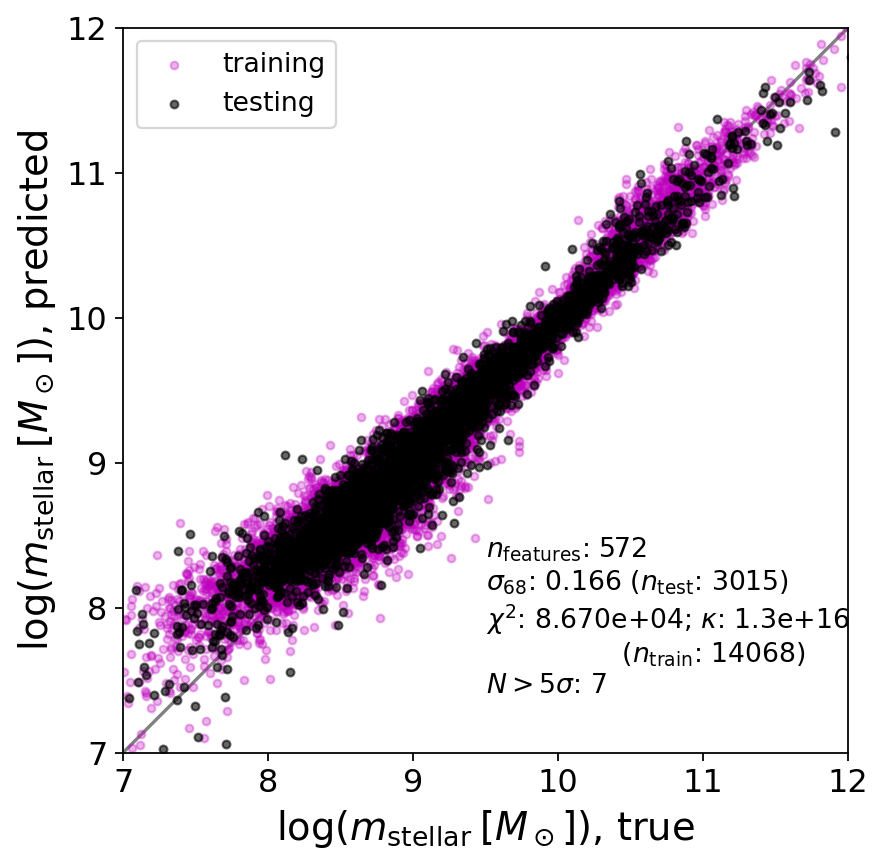

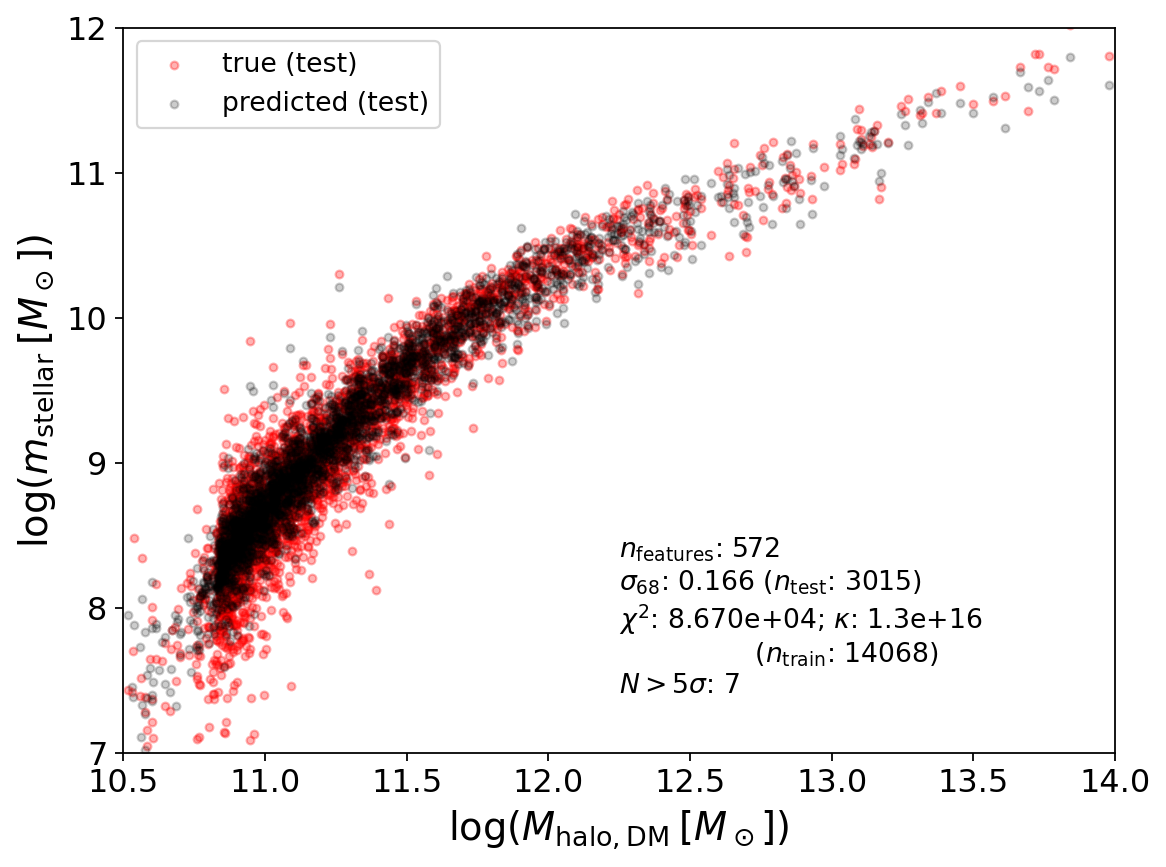

In [24]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test(idx_train, idx_val)
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

In [25]:
chi2_all = fitter.chi2
error_all, n_outliers_all = utils.compute_error(fitter, test_error_type='percentile')
print(error_all)

0.166024259308018


# Feature importance

In [18]:
feature_imp_dir = f'../data/feature_importance/feature_importance_{sim_name}'
feature_tag = '_top1'
fn_feature_imp = f'{feature_imp_dir}/feature_importance{halo_tag}{geo_tag}{scalar_tag}{feature_tag}.npy'
feature_imp_results = feature_importance.load_feature_importance(fn_feature_imp)
idxs_ordered_best, errors_best, chi2s_best, groups = feature_imp_results

In [19]:
feature_arr_all = scalar_featurizer.scalar_feature_arr
feature_names = [s.name for s in feature_arr_all[0]]
for idx in idxs_ordered_best:
    display(Markdown('$'+feature_names[idx]+'$'))

$g_{001}$

$\lambda_1(g_{020}) \, \lambda_1(g_{200})$

$\lambda_3(g_{020}) \, g_{000}$

$\lambda_1(g_{020}) \, g_{001}$

$[g_{110}^A]_{jk} \, [g_{110}^A]_{jk}$

$\lambda_1(g_{021}) \, \lambda_1(g_{202})$

$\lambda_2(g_{110}) \, \lambda_3(g_{201})$

$\lambda_2(g_{020}) \, \lambda_3(g_{022})$

$\lambda_3(g_{021}) \, \lambda_3(g_{022})$

$\lambda_2(g_{020}) \, \lambda_2(g_{201})$

$[g_{110}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{020}) \, g_{000}$

$\lambda_1(g_{111}) \, \lambda_2(g_{111})$

$[g_{112}^A]_{jk} \, [g_{112}^A]_{jk}$

$\lambda_1(g_{200}) \, \lambda_2(g_{021})$

$\lambda_1(g_{021}) \, \lambda_2(g_{022})$

$\lambda_1(g_{112}) \, \lambda_3(g_{112})$

$\lambda_2(g_{021}) \, g_{000}$

$\lambda_3(g_{110}) \, \lambda_3(g_{202})$

$[g_{200}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{022}) \, \lambda_1(g_{111})$

$\lambda_2(g_{112}) \, \lambda_3(g_{201})$

$\lambda_1(g_{022}) \, \lambda_1(g_{110})$

$\lambda_2(g_{110}) \, \lambda_3(g_{111})$

$\lambda_1(g_{021}) \, \lambda_1(g_{110})$

$\lambda_1(g_{021}) \, \lambda_3(g_{200})$

$\lambda_1(g_{022}) \, \lambda_3(g_{202})$

$\lambda_2(g_{111}) \, \lambda_3(g_{021})$

$\lambda_3(g_{022}) \, \lambda_3(g_{201})$

$\lambda_1(g_{111}) \, \lambda_1(g_{112})$

$\lambda_1(g_{110}) \, \lambda_2(g_{112})$

$\lambda_1(g_{112}) \, \lambda_2(g_{202})$

$\lambda_1(g_{022})$

$\lambda_1(g_{021}) \, \lambda_1(g_{201})$

$\lambda_1(g_{021}) \, \lambda_3(g_{022})$

$\lambda_2(g_{112}) \, \lambda_3(g_{111})$

$\lambda_1(g_{022}) \, g_{002}$

$\lambda_1(g_{111}) \, \lambda_3(g_{202})$

$\lambda_2(g_{112}) \, \lambda_3(g_{020})$

$\lambda_2(g_{111}) \, \lambda_3(g_{110})$

$\lambda_1(g_{201}) \, \lambda_2(g_{022})$

$\lambda_1(g_{110}) \, \lambda_1(g_{112})$

$\lambda_1(g_{111}) \, \lambda_2(g_{202})$

$\lambda_3(g_{020}) \, g_{001}$

$\lambda_2(g_{022}) \, \lambda_3(g_{202})$

$[g_{100}]_j \, [g_{101}]_j$

$\lambda_1(g_{202}) \, g_{000}$

$\lambda_1(g_{111}) \, \lambda_1(g_{111})$

$\lambda_1(g_{111}) \, g_{002}$

$\lambda_2(g_{110}) \, \lambda_3(g_{110})$

$\lambda_2(g_{022}) \, \lambda_3(g_{021})$

$\lambda_1(g_{111}) \, \lambda_3(g_{201})$

$[g_{200}]_{jk} \, [g_{111}]_{jk}$

$[g_{020}]_{jk} \, [g_{111}]_{jk}$

$\lambda_2(g_{112}) \, \lambda_2(g_{112})$

$\lambda_2(g_{111}) \, \lambda_2(g_{112})$

$\lambda_1(g_{200}) \, \lambda_2(g_{022})$

$\lambda_2(g_{110}) \, \lambda_3(g_{112})$

$\lambda_1(g_{022}) \, \lambda_2(g_{112})$

$\lambda_3(g_{202}) \, \lambda_3(g_{202})$

$\lambda_1(g_{022}) \, \lambda_2(g_{020})$

$\lambda_1(g_{110}) \, \lambda_2(g_{111})$

$\lambda_2(g_{112}) \, g_{001}$

$\lambda_2(g_{112}) \, \lambda_2(g_{202})$

$\lambda_1(g_{201}) \, \lambda_3(g_{022})$

$\lambda_2(g_{022}) \, g_{002}$

$\lambda_3(g_{022}) \, g_{001}$

$[g_{112}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{202}) \, \lambda_3(g_{110})$

$\lambda_2(g_{112}) \, \lambda_3(g_{021})$

$\lambda_1(g_{112}) \, \lambda_3(g_{020})$

$\lambda_1(g_{020}) \, \lambda_1(g_{110})$

$[g_{201}]_{jk} \, [g_{112}]_{jk}$

$[g_{111}]_{jk} \, [g_{112}]_{jk}$

$\lambda_2(g_{021})$

$\lambda_2(g_{110})$

$\lambda_1(g_{112}) \, \lambda_2(g_{112})$

$\lambda_2(g_{112}) \, g_{002}$

$\lambda_3(g_{110}) \, \lambda_3(g_{112})$

$[g_{011}]_j \, [g_{102}]_j$

$\lambda_2(g_{022}) \, g_{001}$

$\lambda_1(g_{200}) \, \lambda_1(g_{201})$

$\lambda_2(g_{200}) \, \lambda_3(g_{022})$

$\lambda_1(g_{200})$

$\lambda_2(g_{112}) \, \lambda_3(g_{022})$

$\lambda_2(g_{112})$

$\lambda_2(g_{112}) \, g_{000}$

$\lambda_1(g_{111}) \, \lambda_2(g_{200})$

$\lambda_1(g_{110}) \, \lambda_1(g_{111})$

$\lambda_1(g_{021}) \, \lambda_2(g_{112})$

$\lambda_1(g_{112}) \, \lambda_3(g_{110})$

$\lambda_1(g_{022}) \, \lambda_3(g_{110})$

$\lambda_1(g_{200}) \, \lambda_2(g_{110})$

$\lambda_1(g_{111}) \, \lambda_3(g_{112})$

$\lambda_1(g_{112}) \, \lambda_2(g_{110})$

$\lambda_1(g_{111}) \, g_{001}$

$\lambda_3(g_{022}) \, \lambda_3(g_{110})$

$\lambda_1(g_{110}) \, \lambda_3(g_{112})$

$\lambda_1(g_{110}) \, \lambda_1(g_{200})$

$\lambda_2(g_{110}) \, \lambda_2(g_{201})$

$\lambda_2(g_{201}) \, \lambda_2(g_{201})$

$\lambda_1(g_{200}) \, \lambda_2(g_{201})$

$[g_{021}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{111}) \, \lambda_2(g_{112})$

$[g_{022}]_{jk} \, [g_{022}]_{jk}$

$\lambda_1(g_{111}) \, \lambda_3(g_{022})$

$[g_{101}]_j \, [g_{102}]_j$

$\lambda_2(g_{112}) \, \lambda_3(g_{202})$

$[g_{012}]_j \, [g_{102}]_j$

$\lambda_1(g_{202}) \, \lambda_3(g_{112})$

$\lambda_1(g_{020}) \, \lambda_3(g_{112})$

$\lambda_1(g_{022}) \, \lambda_3(g_{022})$

$\lambda_2(g_{110}) \, \lambda_3(g_{202})$

$\lambda_2(g_{022}) \, \lambda_2(g_{200})$

$\lambda_1(g_{110}) \, \lambda_3(g_{111})$

$\lambda_2(g_{111}) \, \lambda_3(g_{022})$

$\lambda_1(g_{020}) \, g_{002}$

$\lambda_2(g_{111}) \, \lambda_3(g_{112})$

$\lambda_1(g_{200}) \, \lambda_3(g_{022})$

$\lambda_3(g_{112}) \, g_{000}$

$\lambda_2(g_{110}) \, g_{002}$

$[g_{010}]_j \, [g_{102}]_j$

$[g_{100}]_j \, [g_{102}]_j$

$\lambda_1(g_{022}) \, \lambda_2(g_{110})$

$[g_{012}]_j \, [g_{012}]_j$

$\lambda_1(g_{020}) \, \lambda_2(g_{112})$

$\lambda_3(g_{020}) \, \lambda_3(g_{112})$

$\lambda_3(g_{111}) \, \lambda_3(g_{202})$

$\lambda_2(g_{021}) \, \lambda_2(g_{112})$

$\lambda_2(g_{112}) \, \lambda_3(g_{110})$

$[g_{111}^A]_{jk} \, [g_{111}^A]_{jk}$

$\lambda_2(g_{020}) \, \lambda_2(g_{112})$

$\lambda_2(g_{022}) \, \lambda_2(g_{112})$

$\lambda_3(g_{021}) \, \lambda_3(g_{112})$

$\lambda_1(g_{112}) \, \lambda_3(g_{021})$

$[g_{111}]_{jk} \, [g_{022}]_{jk}$

$\lambda_1(g_{112}) \, \lambda_3(g_{111})$

$\lambda_2(g_{110}) \, \lambda_2(g_{200})$

$[g_{100}]_j \, [g_{100}]_j$

$\lambda_3(g_{022}) \, \lambda_3(g_{111})$

$\lambda_1(g_{021}) \, \lambda_1(g_{112})$

$\lambda_1(g_{022}) \, \lambda_3(g_{021})$

$\lambda_2(g_{022}) \, \lambda_3(g_{111})$

$\lambda_1(g_{111}) \, \lambda_2(g_{022})$

$\lambda_2(g_{201}) \, g_{001}$

$\lambda_2(g_{110}) \, \lambda_3(g_{200})$

$\lambda_3(g_{111}) \, \lambda_3(g_{112})$

$\lambda_2(g_{021}) \, \lambda_2(g_{200})$

$\lambda_1(g_{112}) \, \lambda_2(g_{111})$

$\lambda_2(g_{202}) \, \lambda_3(g_{111})$

$[g_{020}]_{jk} \, [g_{201}]_{jk}$

$\lambda_1(g_{202}) \, \lambda_3(g_{021})$

$[g_{101}]_j \, [g_{101}]_j$

$\lambda_1(g_{200}) \, \lambda_3(g_{201})$

$\lambda_1(g_{020}) \, \lambda_3(g_{201})$

$\lambda_2(g_{020}) \, \lambda_2(g_{022})$

$\lambda_2(g_{022}) \, \lambda_3(g_{022})$

$[g_{110}]_{jk} \, [g_{112}]_{jk}$

$\lambda_3(g_{201}) \, g_{000}$

$[g_{021}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{202}) \, \lambda_3(g_{111})$

$\lambda_1(g_{110}) \, \lambda_2(g_{022})$

$\lambda_1(g_{021}) \, \lambda_1(g_{111})$

$[g_{111}^A]_{jk} \, [g_{112}^A]_{jk}$

$\lambda_2(g_{112}) \, \lambda_3(g_{112})$

$\lambda_1(g_{111}) \, \lambda_3(g_{021})$

$\lambda_3(g_{111}) \, g_{002}$

$\lambda_1(g_{022}) \, \lambda_2(g_{111})$

$\lambda_1(g_{022}) \, \lambda_3(g_{111})$

$\lambda_2(g_{112}) \, \lambda_2(g_{201})$

$\lambda_2(g_{110}) \, \lambda_2(g_{112})$

$[g_{100}]_j \, [g_{012}]_j$

$\lambda_2(g_{111}) \, \lambda_2(g_{202})$

$\lambda_2(g_{111}) \, \lambda_3(g_{202})$

$\lambda_1(g_{110}) \, \lambda_3(g_{022})$

$\lambda_2(g_{202}) \, \lambda_3(g_{202})$

$\lambda_3(g_{022})$

$\lambda_2(g_{022}) \, \lambda_2(g_{111})$

$\lambda_1(g_{021}) \, \lambda_3(g_{112})$

$\lambda_2(g_{202}) \, \lambda_3(g_{110})$

$[g_{200}]_{jk} \, [g_{021}]_{jk}$

$\lambda_2(g_{110}) \, \lambda_2(g_{202})$

$\lambda_2(g_{112}) \, \lambda_2(g_{200})$

$\lambda_1(g_{021}) \, \lambda_2(g_{020})$

$\lambda_2(g_{200}) \, \lambda_3(g_{202})$

$\lambda_1(g_{110}) \, \lambda_2(g_{202})$

$[g_{102}]_j \, [g_{102}]_j$

$\lambda_1(g_{021}) \, \lambda_3(g_{202})$

$\lambda_2(g_{020}) \, \lambda_3(g_{202})$

$\lambda_1(g_{110}) \, \lambda_3(g_{202})$

$\lambda_2(g_{201}) \, \lambda_3(g_{111})$

$\lambda_1(g_{200}) \, \lambda_3(g_{202})$

$\lambda_3(g_{202}) \, g_{001}$

$\lambda_2(g_{021}) \, \lambda_3(g_{111})$

$\lambda_3(g_{111}) \, \lambda_3(g_{201})$

$\lambda_2(g_{020}) \, \lambda_3(g_{111})$

$\lambda_1(g_{022}) \, \lambda_2(g_{202})$

$\lambda_2(g_{202}) \, \lambda_2(g_{202})$

$\lambda_2(g_{202}) \, \lambda_3(g_{021})$

$\lambda_1(g_{112}) \, \lambda_3(g_{202})$

$\lambda_2(g_{021}) \, \lambda_2(g_{022})$

$\lambda_2(g_{202}) \, \lambda_3(g_{201})$

$\lambda_2(g_{021}) \, \lambda_3(g_{112})$

$[g_{101}]_j \, [g_{012}]_j$

$\lambda_1(g_{202}) \, \lambda_2(g_{202})$

$\lambda_2(g_{022}) \, \lambda_2(g_{202})$

$\lambda_2(g_{021}) \, \lambda_3(g_{022})$

$\lambda_2(g_{202}) \, g_{000}$

$\lambda_1(g_{201}) \, g_{000}$

$\lambda_1(g_{020}) \, \lambda_1(g_{201})$

$\lambda_2(g_{112}) \, \lambda_3(g_{200})$

$\lambda_1(g_{020}) \, \lambda_2(g_{202})$

$\lambda_2(g_{110}) \, \lambda_3(g_{022})$

$\lambda_3(g_{110}) \, \lambda_3(g_{110})$

$\lambda_1(g_{200}) \, \lambda_1(g_{200})$

$\lambda_1(g_{021}) \, \lambda_1(g_{200})$

$\lambda_2(g_{020}) \, \lambda_3(g_{112})$

$\lambda_1(g_{111}) \, \lambda_2(g_{201})$

$\lambda_1(g_{111}) \, \lambda_1(g_{202})$

$\lambda_3(g_{112}) \, \lambda_3(g_{200})$

$\lambda_2(g_{020}) \, \lambda_3(g_{110})$

$[g_{110}^A]_{jk} \, [g_{111}^A]_{jk}$

$\lambda_1(g_{201}) \, \lambda_2(g_{020})$

$\lambda_3(g_{202})$

$\lambda_2(g_{201}) \, \lambda_3(g_{020})$

$\lambda_1(g_{200}) \, \lambda_2(g_{020})$

$\lambda_3(g_{020}) \, \lambda_3(g_{202})$

$\lambda_3(g_{020}) \, \lambda_3(g_{022})$

$\lambda_1(g_{201}) \, \lambda_2(g_{021})$

$\lambda_1(g_{112}) \, \lambda_3(g_{200})$

$\lambda_3(g_{020}) \, \lambda_3(g_{110})$

$\lambda_3(g_{200}) \, g_{001}$

$\lambda_1(g_{200}) \, \lambda_2(g_{112})$

$\lambda_1(g_{111}) \, \lambda_3(g_{020})$

$\lambda_1(g_{202}) \, \lambda_2(g_{021})$

$[g_{020}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{201}) \, \lambda_2(g_{201})$

$\lambda_1(g_{112}) \, \lambda_2(g_{021})$

$\lambda_1(g_{200}) \, \lambda_3(g_{112})$

$\lambda_2(g_{200}) \, g_{001}$

$\lambda_2(g_{021}) \, \lambda_2(g_{201})$

$\lambda_1(g_{021}) \, \lambda_2(g_{202})$

$\lambda_1(g_{110}) \, \lambda_1(g_{202})$

$\lambda_1(g_{112}) \, \lambda_2(g_{020})$

$\lambda_2(g_{021}) \, \lambda_3(g_{200})$

$\lambda_2(g_{111}) \, g_{002}$

$\lambda_1(g_{022}) \, \lambda_2(g_{021})$

$\lambda_1(g_{021}) \, \lambda_2(g_{111})$

$\lambda_2(g_{021}) \, \lambda_2(g_{111})$

$\lambda_2(g_{201}) \, \lambda_2(g_{202})$

$\lambda_3(g_{200}) \, \lambda_3(g_{202})$

$\lambda_3(g_{110}) \, g_{002}$

$\lambda_1(g_{110}) \, g_{001}$

$\lambda_3(g_{111}) \, \lambda_3(g_{200})$

$\lambda_3(g_{202}) \, g_{000}$

$\lambda_3(g_{201})$

$\lambda_2(g_{020}) \, \lambda_2(g_{020})$

$\lambda_3(g_{022}) \, \lambda_3(g_{202})$

$\lambda_3(g_{202}) \, g_{002}$

$[g_{110}]_{jk} \, [g_{110}]_{jk}$

$\lambda_2(g_{020}) \, g_{001}$

$\lambda_1(g_{110}) \, \lambda_3(g_{201})$

$\lambda_1(g_{200}) \, \lambda_2(g_{202})$

$\lambda_2(g_{200}) \, \lambda_3(g_{111})$

$\lambda_1(g_{111}) \, \lambda_3(g_{111})$

$\lambda_1(g_{110}) \, \lambda_2(g_{110})$

$\lambda_1(g_{111}) \, \lambda_3(g_{200})$

$\lambda_2(g_{022}) \, \lambda_3(g_{020})$

$\lambda_2(g_{022}) \, \lambda_2(g_{110})$

$\lambda_2(g_{202}) \, \lambda_3(g_{022})$

$g_{000} \, g_{002}$

$\lambda_2(g_{020}) \, \lambda_3(g_{020})$

$\lambda_2(g_{202}) \, \lambda_3(g_{112})$

$\lambda_2(g_{020}) \, \lambda_2(g_{110})$

$\lambda_1(g_{110}) \, \lambda_2(g_{021})$

$\lambda_1(g_{110}) \, \lambda_2(g_{201})$

$\lambda_2(g_{111}) \, \lambda_2(g_{111})$

$\lambda_1(g_{112}) \, \lambda_1(g_{200})$

$\lambda_3(g_{111}) \, g_{000}$

$[g_{100}]_j \, [g_{011}]_j$

$\lambda_1(g_{020}) \, \lambda_2(g_{201})$

$\lambda_2(g_{111}) \, \lambda_2(g_{201})$

$\lambda_3(g_{112}) \, \lambda_3(g_{202})$

$\lambda_1(g_{022}) \, \lambda_1(g_{112})$

$\lambda_1(g_{112}) \, \lambda_1(g_{112})$

$\lambda_1(g_{110}) \, \lambda_3(g_{200})$

$\lambda_1(g_{202}) \, g_{002}$

$\lambda_2(g_{111}) \, \lambda_3(g_{201})$

$\lambda_3(g_{112}) \, \lambda_3(g_{112})$

$\lambda_1(g_{022}) \, \lambda_3(g_{112})$

$\lambda_1(g_{112}) \, \lambda_2(g_{200})$

$\lambda_1(g_{111}) \, \lambda_2(g_{020})$

$\lambda_1(g_{111}) \, \lambda_3(g_{110})$

$\lambda_1(g_{111}) \, \lambda_2(g_{110})$

$[g_{010}]_j \, [g_{100}]_j$

$\lambda_3(g_{112}) \, g_{001}$

$\lambda_1(g_{111}) \, \lambda_1(g_{200})$

$\lambda_2(g_{202}) \, g_{002}$

$\lambda_1(g_{022}) \, g_{000}$

$\lambda_3(g_{200}) \, g_{002}$

$[g_{200}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{020}) \, \lambda_2(g_{202})$

$\lambda_1(g_{022}) \, g_{001}$

$\lambda_2(g_{202}) \, \lambda_3(g_{020})$

$\lambda_1(g_{201}) \, \lambda_3(g_{201})$

$\lambda_1(g_{201}) \, \lambda_2(g_{202})$

$\lambda_1(g_{022}) \, \lambda_3(g_{020})$

$[g_{111}]_{jk} \, [g_{111}]_{jk}$

$\lambda_3(g_{111}) \, \lambda_3(g_{111})$

$\lambda_1(g_{021}) \, \lambda_3(g_{021})$

$\lambda_1(g_{200}) \, \lambda_3(g_{111})$

$\lambda_1(g_{021}) \, \lambda_3(g_{111})$

$\lambda_1(g_{021}) \, g_{000}$

$\lambda_2(g_{200}) \, \lambda_2(g_{202})$

$\lambda_1(g_{022}) \, \lambda_3(g_{200})$

$[g_{200}]_{jk} \, [g_{201}]_{jk}$

$\lambda_2(g_{201}) \, \lambda_3(g_{201})$

$\lambda_1(g_{022}) \, \lambda_2(g_{022})$

$\lambda_3(g_{201}) \, \lambda_3(g_{202})$

$\lambda_3(g_{112}) \, \lambda_3(g_{201})$

$[g_{020}]_{jk} \, [g_{200}]_{jk}$

$\lambda_1(g_{201}) \, \lambda_3(g_{020})$

$\lambda_1(g_{202}) \, \lambda_2(g_{200})$

$\lambda_1(g_{020}) \, \lambda_1(g_{112})$

$\lambda_3(g_{021}) \, g_{002}$

$\lambda_3(g_{021}) \, \lambda_3(g_{202})$

$\lambda_3(g_{020}) \, \lambda_3(g_{111})$

$\lambda_2(g_{021}) \, g_{001}$

$\lambda_2(g_{201}) \, \lambda_3(g_{202})$

$\lambda_1(g_{021}) \, \lambda_1(g_{022})$

$\lambda_2(g_{021}) \, g_{002}$

$\lambda_1(g_{112}) \, g_{000}$

$[g_{021}]_{jk} \, [g_{022}]_{jk}$

$[g_{021}]_{jk} \, [g_{111}]_{jk}$

$\lambda_2(g_{022}) \, \lambda_3(g_{110})$

$[g_{110}]_{jk} \, [g_{111}]_{jk}$

$[g_{011}]_j \, [g_{101}]_j$

$[g_{010}]_j \, [g_{101}]_j$

$\lambda_3(g_{110}) \, \lambda_3(g_{111})$

$[g_{201}]_{jk} \, [g_{022}]_{jk}$

$\lambda_3(g_{201}) \, \lambda_3(g_{201})$

$[g_{110}]_{jk} \, [g_{022}]_{jk}$

$[g_{200}]_{jk} \, [g_{022}]_{jk}$

$\lambda_2(g_{021}) \, \lambda_3(g_{110})$

$[g_{020}]_{jk} \, [g_{202}]_{jk}$

$[g_{010}]_j \, [g_{012}]_j$

$[g_{011}]_j \, [g_{012}]_j$

$\lambda_1(g_{201}) \, \lambda_2(g_{112})$

$\lambda_1(g_{202}) \, \lambda_2(g_{112})$

$[g_{022}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{022}) \, \lambda_3(g_{200})$

$\lambda_1(g_{202}) \, \lambda_2(g_{111})$

$\lambda_2(g_{200}) \, \lambda_2(g_{201})$

$\lambda_2(g_{200}) \, \lambda_3(g_{112})$

$\lambda_1(g_{022}) \, \lambda_2(g_{200})$

$\lambda_1(g_{201}) \, \lambda_3(g_{110})$

$\lambda_3(g_{020}) \, \lambda_3(g_{201})$

$\lambda_1(g_{022}) \, \lambda_2(g_{201})$

$\lambda_1(g_{201}) \, \lambda_2(g_{110})$

$\lambda_1(g_{112}) \, \lambda_2(g_{201})$

$\lambda_1(g_{202}) \, \lambda_2(g_{110})$

$\lambda_2(g_{111}) \, \lambda_3(g_{200})$

$[g_{111}]_{jk} \, [g_{201}]_{jk}$

$[g_{110}^A]_{jk} \, [g_{112}^A]_{jk}$

$\lambda_1(g_{202}) \, \lambda_3(g_{200})$

$\lambda_1(g_{200}) \, \lambda_2(g_{111})$

$\lambda_1(g_{112}) \, \lambda_1(g_{201})$

$\lambda_2(g_{200}) \, g_{002}$

$g_{000} \, g_{001}$

$\lambda_2(g_{201}) \, \lambda_3(g_{112})$

$\lambda_1(g_{020}) \, \lambda_3(g_{111})$

$\lambda_2(g_{020}) \, \lambda_3(g_{201})$

$\lambda_1(g_{110}) \, \lambda_3(g_{021})$

$\lambda_1(g_{021}) \, \lambda_3(g_{201})$

$\lambda_3(g_{021}) \, \lambda_3(g_{200})$

$\lambda_3(g_{021}) \, \lambda_3(g_{110})$

$\lambda_2(g_{021}) \, \lambda_3(g_{021})$

$\lambda_3(g_{021}) \, \lambda_3(g_{021})$

$\lambda_1(g_{020}) \, \lambda_2(g_{022})$

$\lambda_1(g_{200}) \, g_{000}$

$[g_{011}]_j \, [g_{011}]_j$

$\lambda_1(g_{200}) \, \lambda_2(g_{200})$

$\lambda_3(g_{022}) \, \lambda_3(g_{200})$

$\lambda_1(g_{021}) \, g_{002}$

$\lambda_2(g_{201}) \, g_{000}$

$\lambda_1(g_{112}) \, \lambda_3(g_{022})$

$\lambda_1(g_{110}) \, \lambda_3(g_{020})$

$[g_{202}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{202}) \, \lambda_1(g_{202})$

$\lambda_1(g_{022}) \, \lambda_1(g_{201})$

$\lambda_3(g_{112})$

$\lambda_3(g_{112}) \, g_{002}$

$\lambda_1(g_{201}) \, \lambda_3(g_{112})$

$\lambda_1(g_{201}) \, \lambda_1(g_{202})$

$\lambda_1(g_{201}) \, \lambda_3(g_{200})$

$\lambda_1(g_{201}) \, \lambda_2(g_{200})$

$\lambda_2(g_{022}) \, \lambda_3(g_{112})$

$\lambda_3(g_{022}) \, \lambda_3(g_{112})$

$\lambda_3(g_{020}) \, \lambda_3(g_{200})$

$\lambda_2(g_{110}) \, \lambda_3(g_{021})$

$\lambda_2(g_{201}) \, \lambda_3(g_{022})$

$\lambda_1(g_{200}) \, \lambda_3(g_{020})$

$\lambda_1(g_{020}) \, \lambda_2(g_{200})$

$\lambda_2(g_{111}) \, \lambda_2(g_{200})$

$\lambda_1(g_{202}) \, \lambda_3(g_{022})$

$\lambda_1(g_{200}) \, \lambda_3(g_{200})$

$\lambda_1(g_{200}) \, \lambda_1(g_{202})$

$\lambda_1(g_{020}) \, \lambda_1(g_{020})$

$\lambda_2(g_{021}) \, \lambda_2(g_{110})$

$\lambda_2(g_{110}) \, g_{000}$

$\lambda_2(g_{110}) \, g_{001}$

$\lambda_1(g_{021}) \, \lambda_2(g_{200})$

$\lambda_1(g_{111})$

$\lambda_1(g_{111}) \, g_{000}$

$\lambda_1(g_{111}) \, \lambda_1(g_{201})$

$\lambda_1(g_{020}) \, \lambda_1(g_{022})$

$\lambda_1(g_{022}) \, \lambda_1(g_{022})$

$\lambda_2(g_{110}) \, \lambda_3(g_{020})$

$\lambda_1(g_{110}) \, \lambda_3(g_{110})$

$\lambda_1(g_{110}) \, \lambda_1(g_{201})$

$\lambda_3(g_{201}) \, g_{001}$

$\lambda_3(g_{201}) \, g_{002}$

$[g_{020}]_{jk} \, [g_{022}]_{jk}$

$\lambda_1(g_{110}) \, g_{000}$

$\lambda_1(g_{020}) \, \lambda_3(g_{202})$

$\lambda_2(g_{021}) \, \lambda_3(g_{202})$

$\lambda_3(g_{200}) \, \lambda_3(g_{200})$

$\lambda_1(g_{200}) \, \lambda_3(g_{110})$

$\lambda_2(g_{202})$

$\lambda_2(g_{202}) \, g_{001}$

$\lambda_2(g_{021}) \, \lambda_3(g_{201})$

$\lambda_2(g_{021}) \, \lambda_2(g_{202})$

$\lambda_2(g_{202}) \, \lambda_3(g_{200})$

$[g_{110}]_{jk} \, [g_{200}]_{jk}$

$\lambda_2(g_{022}) \, \lambda_2(g_{201})$

$\lambda_1(g_{021}) \, \lambda_1(g_{021})$

$\lambda_1(g_{021})$

$[g_{201}]_{jk} \, [g_{201}]_{jk}$

$\lambda_1(g_{020})$

$g_{001} \, g_{001}$

$g_{001} \, g_{002}$

$\lambda_1(g_{020}) \, g_{000}$

$\lambda_3(g_{021}) \, g_{001}$

$\lambda_1(g_{021}) \, g_{001}$

$\lambda_1(g_{021}) \, \lambda_2(g_{201})$

$\lambda_1(g_{201}) \, \lambda_1(g_{201})$

$\lambda_1(g_{020}) \, \lambda_3(g_{021})$

$[g_{112}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{110}) \, \lambda_1(g_{110})$

$\lambda_2(g_{110}) \, \lambda_2(g_{110})$

$\lambda_2(g_{022})$

$[g_{010}]_j \, [g_{010}]_j$

$\lambda_2(g_{022}) \, g_{000}$

$\lambda_1(g_{020}) \, \lambda_3(g_{022})$

$\lambda_3(g_{022}) \, \lambda_3(g_{022})$

$\lambda_2(g_{022}) \, \lambda_2(g_{022})$

$[g_{010}]_j \, [g_{011}]_j$

$\lambda_2(g_{200}) \, \lambda_3(g_{110})$

$\lambda_2(g_{200}) \, \lambda_3(g_{021})$

$\lambda_2(g_{022}) \, \lambda_3(g_{201})$

$\lambda_2(g_{111})$

$\lambda_1(g_{020}) \, \lambda_2(g_{111})$

$\lambda_2(g_{111}) \, g_{000}$

$\lambda_2(g_{111}) \, g_{001}$

$\lambda_1(g_{202}) \, \lambda_2(g_{022})$

$\lambda_1(g_{201}) \, \lambda_2(g_{111})$

$\lambda_2(g_{111}) \, \lambda_3(g_{020})$

$\lambda_2(g_{020}) \, \lambda_2(g_{111})$

$\lambda_2(g_{200}) \, \lambda_2(g_{200})$

$[g_{200}]_{jk} \, [g_{200}]_{jk}$

$\lambda_1(g_{201})$

$[g_{201}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{201}) \, \lambda_3(g_{021})$

$\lambda_1(g_{201}) \, \lambda_3(g_{202})$

$\lambda_1(g_{202}) \, \lambda_3(g_{202})$

$\lambda_1(g_{021}) \, \lambda_3(g_{020})$

$[g_{021}]_{jk} \, [g_{201}]_{jk}$

$\lambda_1(g_{020}) \, \lambda_1(g_{111})$

$\lambda_1(g_{020}) \, \lambda_2(g_{110})$

$\lambda_1(g_{021}) \, \lambda_2(g_{110})$

$\lambda_1(g_{111}) \, \lambda_2(g_{021})$

$\lambda_3(g_{020}) \, \lambda_3(g_{020})$

$\lambda_2(g_{201})$

$[g_{020}]_{jk} \, [g_{020}]_{jk}$

$\lambda_2(g_{201}) \, g_{002}$

$\lambda_2(g_{201}) \, \lambda_3(g_{021})$

$\lambda_2(g_{200}) \, \lambda_3(g_{200})$

$\lambda_3(g_{020})$

$\lambda_3(g_{020}) \, g_{002}$

$[g_{110}]_{jk} \, [g_{021}]_{jk}$

$\lambda_2(g_{020})$

$\lambda_2(g_{020}) \, \lambda_3(g_{021})$

$\lambda_3(g_{021})$

$\lambda_3(g_{021}) \, g_{000}$

$\lambda_2(g_{020}) \, g_{002}$

$\lambda_3(g_{020}) \, \lambda_3(g_{021})$

$\lambda_1(g_{022}) \, \lambda_1(g_{202})$

$\lambda_2(g_{111}) \, \lambda_3(g_{111})$

$\lambda_2(g_{201}) \, \lambda_3(g_{200})$

$\lambda_1(g_{202}) \, \lambda_2(g_{201})$

$[g_{111}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{020}) \, \lambda_3(g_{200})$

$\lambda_1(g_{110})$

$\lambda_1(g_{110}) \, g_{002}$

$\lambda_1(g_{110}) \, \lambda_2(g_{020})$

$\lambda_1(g_{110}) \, \lambda_2(g_{200})$

$\lambda_2(g_{110}) \, \lambda_2(g_{111})$

$\lambda_3(g_{110}) \, \lambda_3(g_{200})$

$\lambda_1(g_{112}) \, g_{001}$

$\lambda_3(g_{110}) \, \lambda_3(g_{201})$

$[g_{022}]_{jk} \, [g_{112}]_{jk}$

$\lambda_2(g_{200}) \, \lambda_3(g_{020})$

$\lambda_1(g_{202}) \, \lambda_3(g_{020})$

$\lambda_3(g_{110}) \, g_{000}$

$\lambda_1(g_{020}) \, \lambda_3(g_{110})$

$[g_{020}]_{jk} \, [g_{110}]_{jk}$

$[g_{110}]_{jk} \, [g_{201}]_{jk}$

$\lambda_1(g_{112}) \, \lambda_3(g_{201})$

$\lambda_3(g_{110})$

$\lambda_3(g_{110}) \, g_{001}$

$\lambda_1(g_{021}) \, \lambda_3(g_{110})$

$\lambda_2(g_{201}) \, \lambda_3(g_{110})$

$\lambda_1(g_{020}) \, \lambda_2(g_{021})$

$[g_{021}]_{jk} \, [g_{021}]_{jk}$

$\lambda_2(g_{021}) \, \lambda_2(g_{021})$

$\lambda_1(g_{200}) \, \lambda_3(g_{021})$

$\lambda_1(g_{022}) \, \lambda_1(g_{200})$

$\lambda_3(g_{021}) \, \lambda_3(g_{201})$

$\lambda_1(g_{022}) \, \lambda_3(g_{201})$

$\lambda_3(g_{200})$

$\lambda_1(g_{200}) \, g_{001}$

$\lambda_3(g_{200}) \, g_{000}$

$\lambda_1(g_{200}) \, g_{002}$

$\lambda_1(g_{020}) \, \lambda_3(g_{200})$

$\lambda_1(g_{020}) \, \lambda_1(g_{202})$

$\lambda_3(g_{200}) \, \lambda_3(g_{201})$

$[g_{020}]_{jk} \, [g_{021}]_{jk}$

$\lambda_1(g_{112})$

$\lambda_1(g_{020}) \, \lambda_2(g_{020})$

$\lambda_1(g_{020}) \, \lambda_3(g_{020})$

$\lambda_2(g_{020}) \, \lambda_2(g_{021})$

$\lambda_1(g_{020}) \, \lambda_1(g_{021})$

$\lambda_2(g_{021}) \, \lambda_3(g_{020})$

$\lambda_1(g_{021}) \, \lambda_2(g_{021})$

$\lambda_1(g_{112}) \, g_{002}$

$\lambda_1(g_{112}) \, \lambda_2(g_{022})$

$\lambda_1(g_{112}) \, \lambda_1(g_{202})$

$\lambda_3(g_{111})$

$\lambda_3(g_{111}) \, g_{001}$

$\lambda_3(g_{021}) \, \lambda_3(g_{111})$

$\lambda_1(g_{201}) \, \lambda_3(g_{111})$

$g_{000}$

$g_{002}$

$\lambda_2(g_{200})$

$\lambda_1(g_{202})$

$g_{000} \, g_{000}$

$g_{002} \, g_{002}$

$\lambda_3(g_{022}) \, g_{000}$

$\lambda_3(g_{022}) \, g_{002}$

$\lambda_2(g_{200}) \, g_{000}$

$\lambda_1(g_{201}) \, g_{001}$

$\lambda_1(g_{201}) \, g_{002}$

$\lambda_1(g_{202}) \, g_{001}$

$\lambda_2(g_{020}) \, \lambda_2(g_{200})$

$\lambda_1(g_{202}) \, \lambda_2(g_{020})$

$\lambda_2(g_{200}) \, \lambda_3(g_{201})$

$\lambda_1(g_{202}) \, \lambda_3(g_{201})$

339


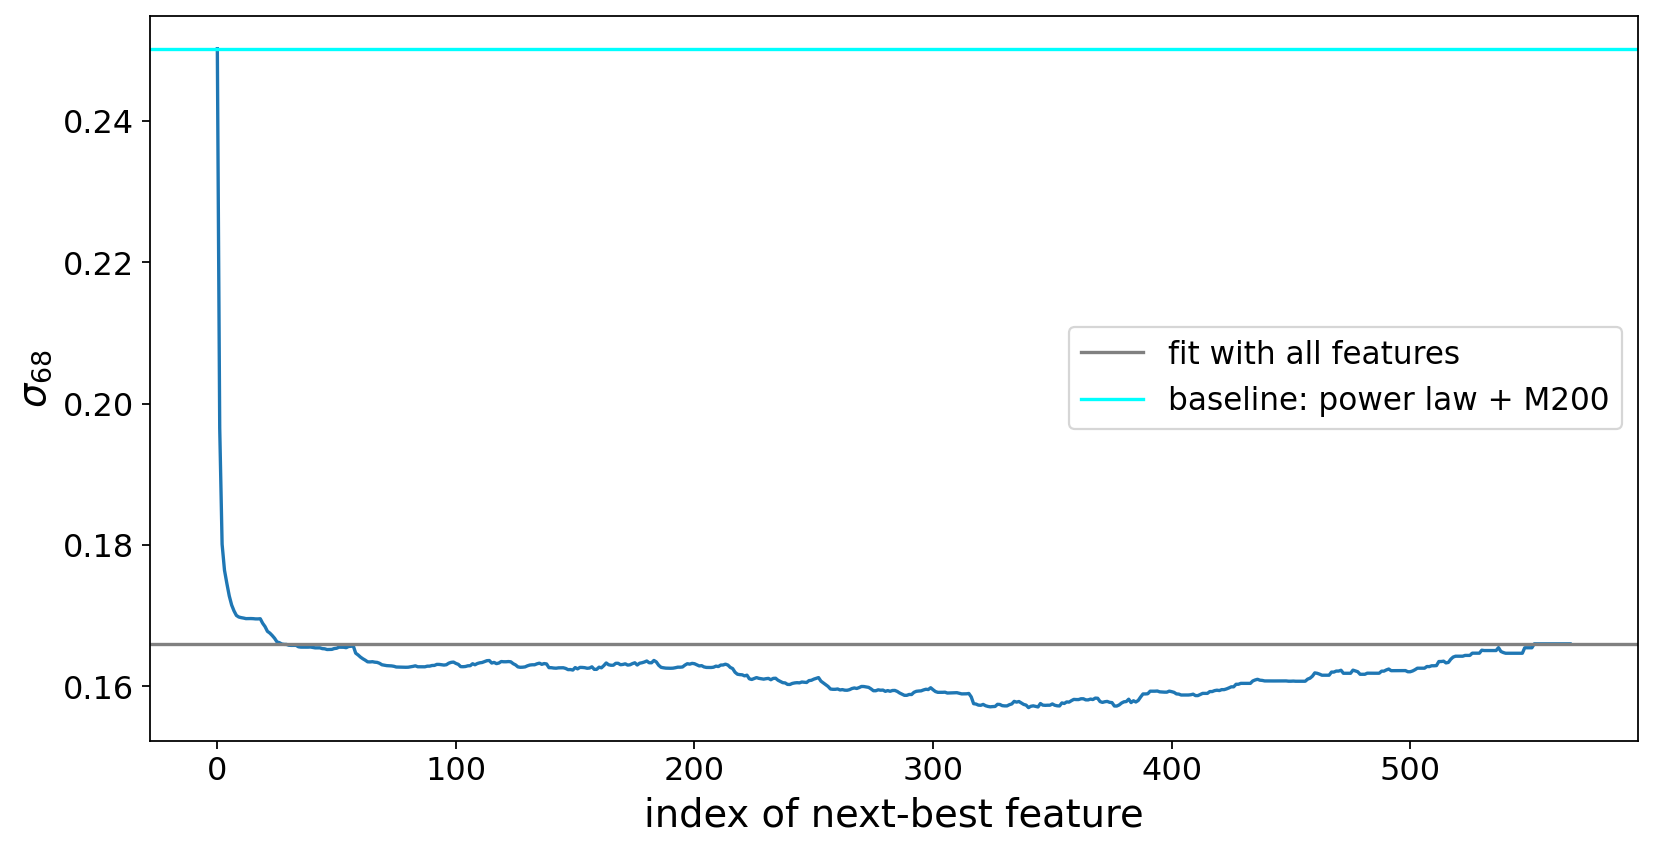

In [26]:
plt.figure(figsize=(12,6))
errors_best_withfirst = [error_powerlawM] + errors_best
plt.plot(errors_best_withfirst)
plt.axhline(error_all, color='grey', label='fit with all features')
#plt.axhline(error_powerlaw, color='magenta', label='fit with all')
plt.axhline(error_powerlawM, color='cyan', label='baseline: power law + M200')

n_min = np.argmin(errors_best)
#plt.axvline(5, color='darkgrey', ls='--')
#plt.axvline(22, color='darkgrey', ls='--')
#plt.axvline(n_min, color='darkgrey', ls='--')
print(n_min)
plt.xlabel('index of next-best feature')
plt.ylabel(r'$\sigma_{68}$')

plt.legend(fontsize=14)

### Visualize halos

In [21]:
nrows = 2
ncols = 3
n_plot = nrows * ncols

In [29]:
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')
features_all = scalar_featurizer.scalar_features

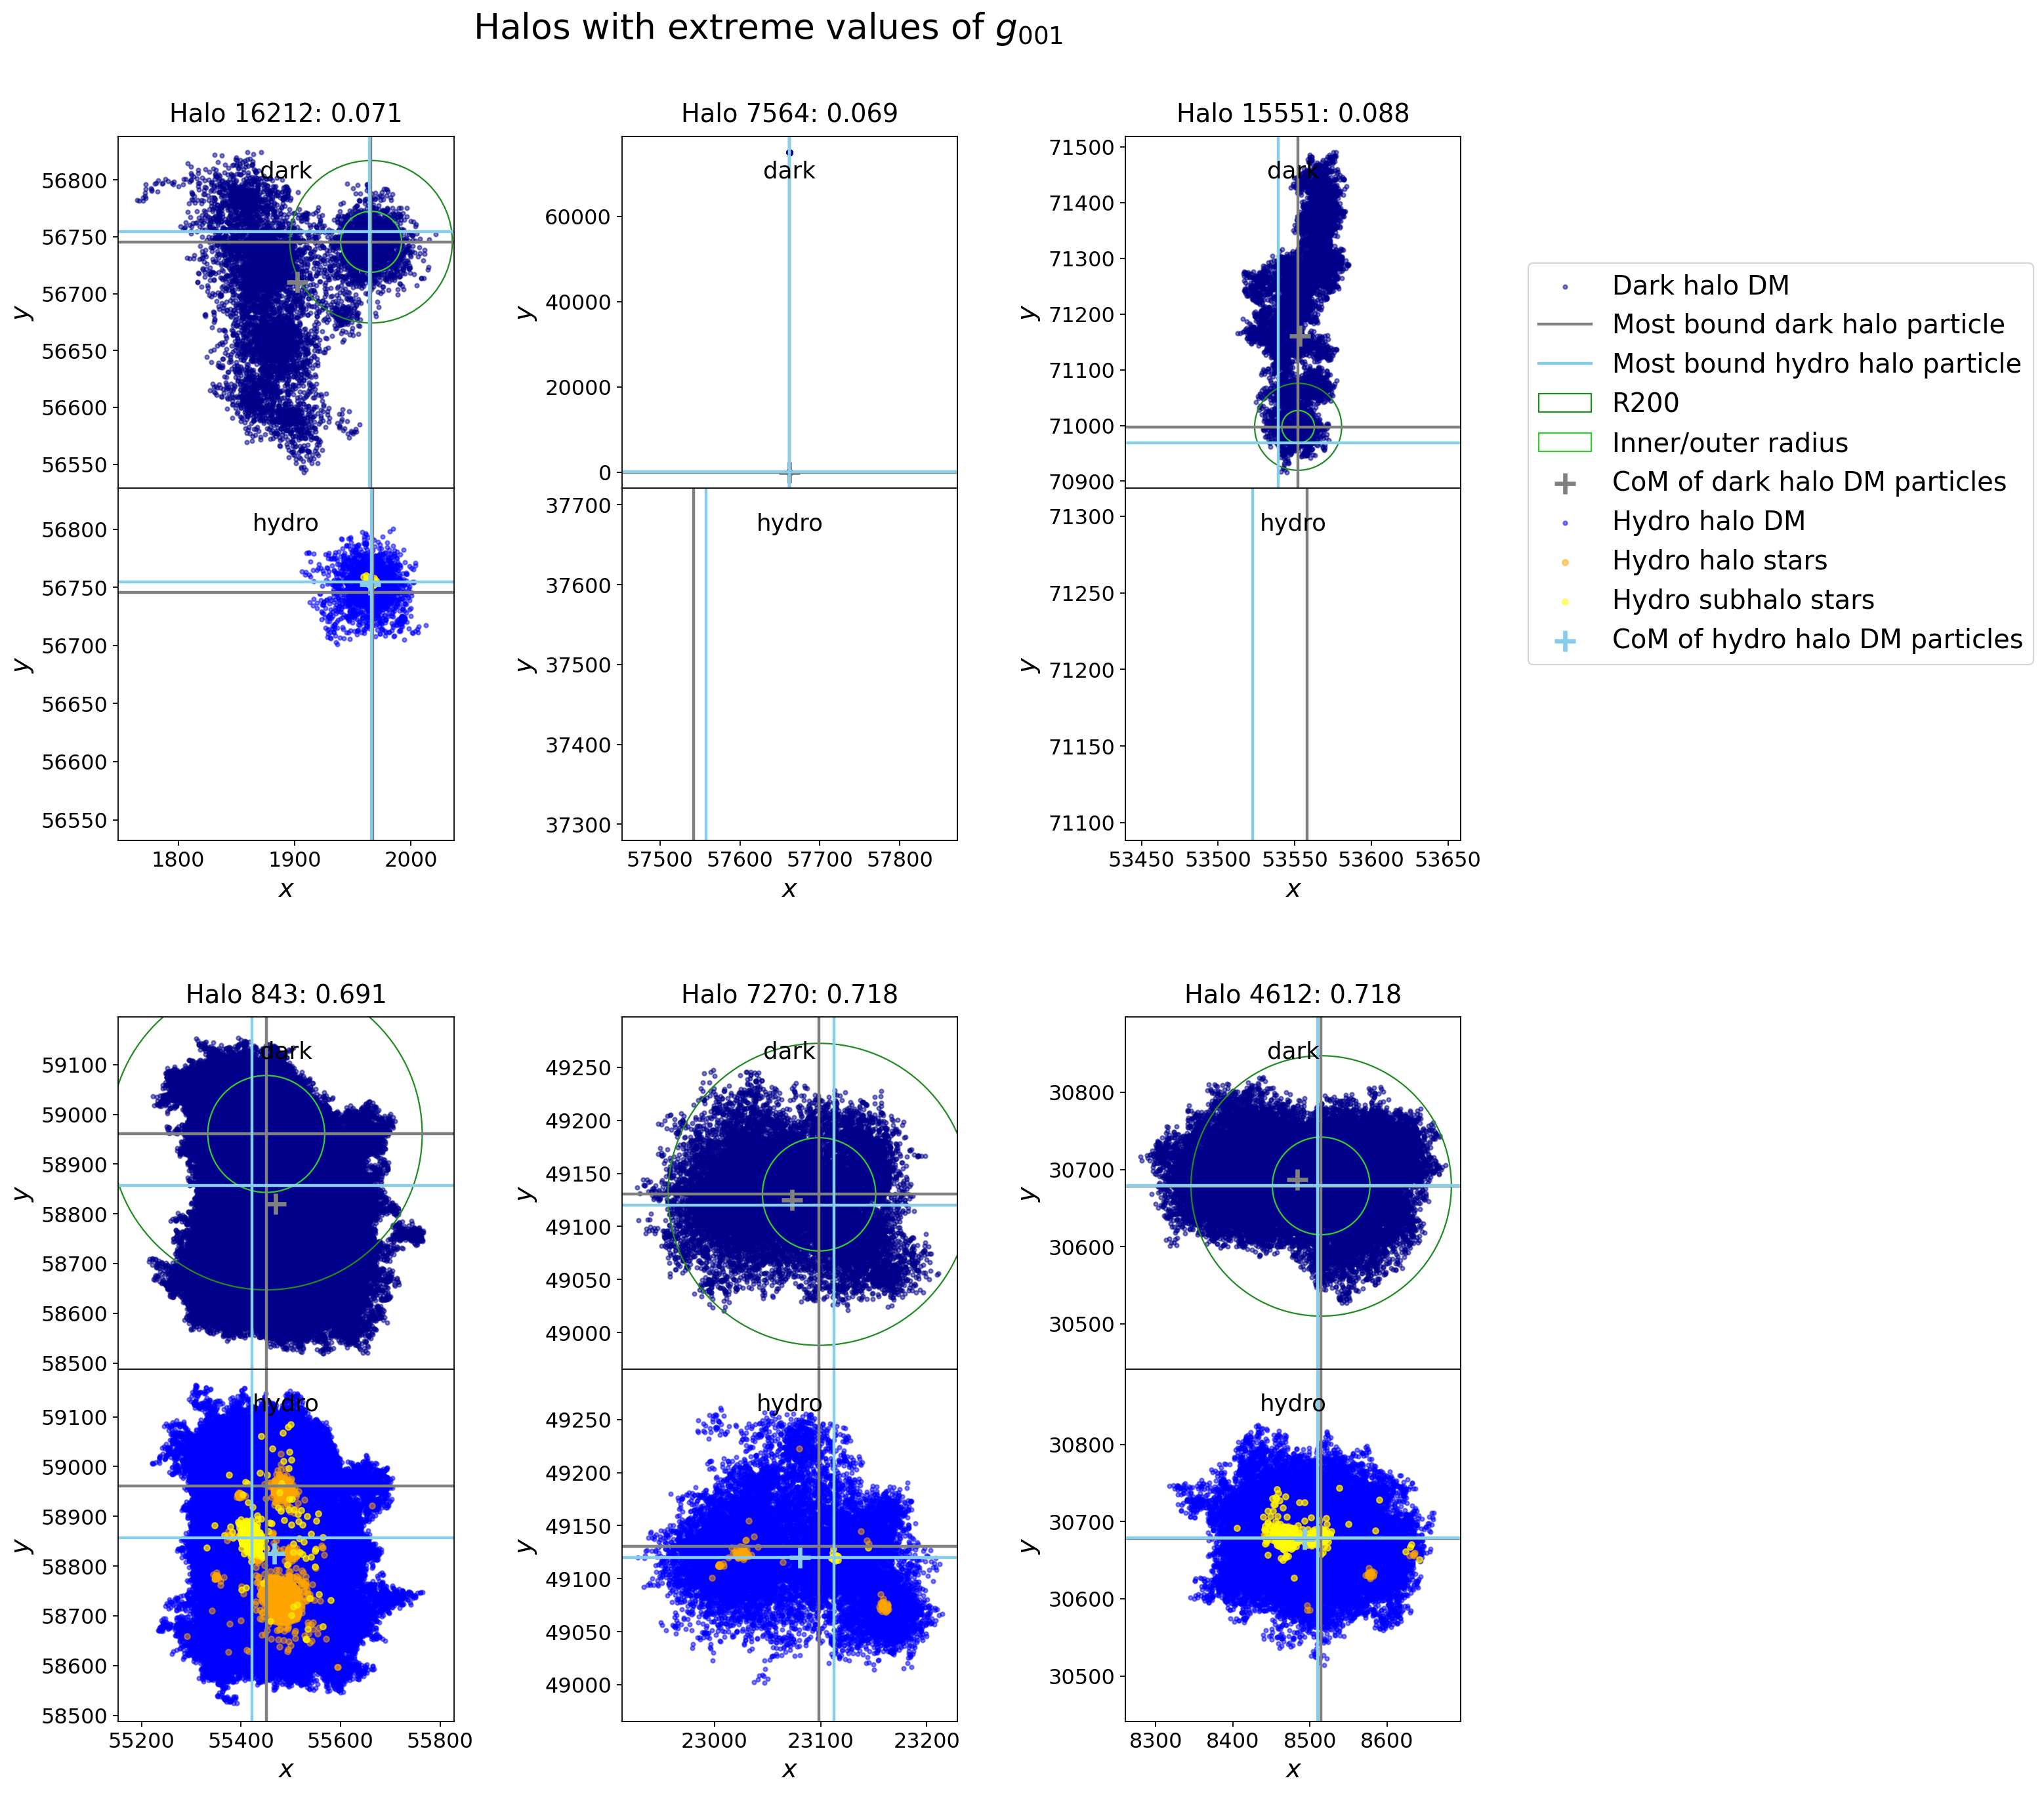

In [30]:
i_best = 0
idx_feat = idxs_ordered_best[i_best]
name_feat = 'Halos with extreme values of $'+feature_arr_all[0][idx_feat].name+'$'
n_each = int(n_plot/2)
idxs_halos_low = np.argpartition(features_all[:,idx_feat], n_each)[:n_each]
idxs_halos_high = np.argpartition(features_all[:,idx_feat], -n_each)[-n_each:]
idxs_halos = np.concatenate((idxs_halos_low, idxs_halos_high))
halos = sim_reader.dark_halo_arr[idxs_halos]
titles = [f'Halo {idx_halo}: {features_all[idx_halo, idx_feat]:.3f}' for idx_halo in idxs_halos]
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=name_feat)

In [ ]:
i_best = 1
idx_feat = idxs_ordered_best[i_best]
name_feat = 'Halos with extreme values of $'+feature_arr_all[0][idx_feat].name+'$'
n_each = int(n_plot/2)
idxs_halos_low = np.argpartition(features_all[:,idx_feat], n_each)[:n_each]
idxs_halos_high = np.argpartition(features_all[:,idx_feat], -n_each)[-n_each:]
idxs_halos = np.concatenate((idxs_halos_low, idxs_halos_high))
halos = sim_reader.dark_halo_arr[idxs_halos]
titles = [f'Halo {idx_halo}: {features_all[idx_halo, idx_feat]:.3f}' for idx_halo in idxs_halos]
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=name_feat)

In [ ]:
i_best = 2
idx_feat = idxs_ordered_best[i_best]
name_feat = 'Halos with extreme values of $'+feature_arr_all[0][idx_feat].name+'$'
n_each = int(n_plot/2)
idxs_halos_low = np.argpartition(features_all[:,idx_feat], n_each)[:n_each]
idxs_halos_high = np.argpartition(features_all[:,idx_feat], -n_each)[-n_each:]
idxs_halos = np.concatenate((idxs_halos_low, idxs_halos_high))
halos = sim_reader.dark_halo_arr[idxs_halos]
titles = [f'Halo {idx_halo}: {features_all[idx_halo, idx_feat]:.3f}' for idx_halo in idxs_halos]
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=name_feat)

# Fitting other properties

In [ ]:
sim_reader.add_catalog_property_to_halos('radius_hydro_subhalo_star')
radius_stellar = np.array([dark_halo.catalog_properties['radius_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
log_radius_stellar = np.log10(radius_stellar)

sim_reader.add_catalog_property_to_halos('sfr_hydro_subhalo_star')
sfr = np.array([dark_halo.catalog_properties['sfr_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
log_sfr = np.log10(sfr)

In [ ]:
ones = np.ones(len(radius_stellar))

In [ ]:
y_label=r'log($R_\mathrm{stellar}$ [ckpc/h])'
print(np.min(radius_stellar), np.max(radius_stellar))
bins = np.linspace(-1, 2)
_ = plt.hist(log_radius_stellar, bins=bins)
plt.xlabel(y_label)
plt.ylabel('count')

In [ ]:
idx_nonzero = np.where(log_radius_stellar > 0)[0]

frac_train, frac_test = 0.70, 0.15
random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr[idx_nonzero]])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

In [ ]:
fitter = LinearFitter(scalar_featurizer.scalar_features[idx_nonzero], log_radius_stellar[idx_nonzero], 
                    ones[idx_nonzero], uncertainties=None,
                    x_features_extra=x_features_extra[idx_nonzero])
fitter.split_train_test(idx_train, idx_test)
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
lim = (-1,2)
plotter.plot_fits(fitter, log_radius_stellar[idx_nonzero], y_lim=lim, y_label=y_label)

In [ ]:
print(np.min(log_radius_stellar[idx_nonzero]), np.max(log_radius_stellar[idx_nonzero]))
print(np.min(fitter.y_scalar_test), np.max(fitter.y_scalar_test))
print(np.min(fitter.y_scalar_test_scaled), np.max(fitter.y_scalar_test_scaled))
print(np.min(fitter.y_scalar), np.max(fitter.y_scalar))

In [ ]:
idx_nonzero = np.where(log_sfr > 0)[0]

frac_train, frac_test = 0.70, 0.15
random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr[idx_nonzero]])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

In [ ]:
y_label=r'log(SFR $[M_\odot/yr]$)'
print(np.min(sfr), np.max(sfr))
bins = np.linspace(-4, 2)
_ = plt.hist(log_sfr, bins=bins)
plt.xlabel(y_label)
plt.ylabel('count')

In [ ]:
fitter = LinearFitter(scalar_featurizer.scalar_features[idx_nonzero], log_sfr[idx_nonzero], 
                    ones[idx_nonzero], uncertainties=None,
                    x_features_extra=x_features_extra[idx_nonzero])
fitter.split_train_test(idx_train, idx_test)
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
lim = (-4, 2)
plotter.plot_fits(fitter, log_sfr[idx_nonzero], y_lim=lim, y_label=y_label)

In [ ]:
print(np.min(log_sfr[idx_nonzero]), np.max(log_sfr[idx_nonzero]))
print(np.min(fitter.y_scalar_test), np.max(fitter.y_scalar_test))
print(np.min(fitter.y_scalar_test_scaled), np.max(fitter.y_scalar_test_scaled))
print(np.min(fitter.y_scalar), np.max(fitter.y_scalar))